In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [1079]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix


In [1080]:
pd.set_option('display.max_columns',0)
pd.options.display.float_format = '{:.2f}'.format

In [1081]:
df=pd.read_csv('data.csv').drop(['Unnamed: 0'], 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, var_366 to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [1083]:
#summary of the numerical attributes
df.describe()

,var_366,var_364,var_38,var_39,var_40,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_41,var_42,var_43,var_60,var_95,var_75,var_113,var_96,var_141,var_140,var_143,var_142,var_147,var_146,var_79,var_78,var_81,var_83,var_82,var_85,var_84,var_87,var_86,var_80,var_89,var_88,var_91,var_90,var_93,var_92,var_94,var_98,var_97,var_100,var_99,var_103,var_105,var_106,var_104,var_102,var_101,var_108,var_110,var_109,var_107,...,var_274,var_203,var_204,var_205,var_206,var_207,var_208,var_209,var_210,var_211,var_291,var_292,var_277,var_278,var_279,var_280,var_349,var_325,var_326,var_327,var_328,var_329,var_330,var_331,var_332,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300,var_301,var_302,var_303,var_304,var_305,var_306,var_307,var_308,var_309,var_310,var_311,var_312,var_313,var_314,var_315,var_316,var_317,var_318,var_319,var_320,var_321,var_322,var_323,var_324,var_368,ID,TARGET
count,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,...,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00
mean,-1523.20,33.21,86.21,72.36,119.53,3.56,6.47,0.41,0.57,3.16,68.80,113.06,68.21,113.23,137.24,68.62,113.79,140.40,5.48,0.01,0.00,0.00,0.00,0.96,0.66,0.00,0.00,0.03,0.03,0.07,0.05,0.05,0.04,0.04,0.01,0.01,0.00,0.00,0.05,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.04,0.03,0.02,0.03,0.02,0.02,0.02,0.00,0.00,0.00,0.00,...,0.81,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.39,3.89,4.36,13.65,0.00,1579.14,891.37,1077.26,1048.86,68.28,9.51,124.62,110.03,3997.02,613.53,5703.01,4401.00,3639.42,556.18,4852.26,3857.85,771.23,162.17,956.95,750.96,0.18,0.00,0.51,0.34,91.17,36.46,131.03,109.22,0.21,0.00,0.25,0.19,7.94,1.37,12.22,8.78,31.51,1.86,76.03,56.61,117235.81,75964.05,0.04
std,39033.46,12.96,1614.76,339.32,546.27,93.16,153.74,30.60,36.51,95.27,319.61,512.15,531.90,950.09,697.71,535.47,953.58,712.77,465.39,0.11,0.06,0.00,0.00,0.20,0.47,0.01,0.01,0.18,0.17,0.25,0.21,0.22,0.20,0.20,0.10,0.10,0.01,0.01,0.22,0.15,0.07,0.04,0.04,0.01,0.01,0.06,0.06,0.05,0.20,0.19,0.16,0.16,0.16,0.16,0.15,0.15,0.00,0.00,0.00,0.00,...,3.56,1.17,0.02,0.02,0.00,0.02,0.03,0.03,0.00,0.01,0.03,0.26,14.50,10.42,14.41,33.30,0.00,12148.45,9888.60,9614.91,8189.95,1733.84,519.39,2205.25,1935.31,37773.14,9292.75,46202.54,35507.18,26359.17,7182.64,31886.62,25572.25,13082.16,4698.87,16006.98,12422.52,34.63,0.00,113.60,73.38,15392.48,8612.40,14956.53,13082.16,41.82,0.53,52.08,31.88,455.89,113.96,783.21,538.44,2013.13,147.79,4040.34,2852.58,182664.60,43781.95,0.19
min,-999999.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-128.37,-8.04,-922.38,-476.07,-287.67,0.00,-3401.34,-1844.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [1084]:
#check for null values, if any
df.isnull().values.any()

False

In [1085]:
# check for columns with only zeroes
cols_zero_val = df.columns[(df == 0).all()]

# since the datatypes of all columns are either int64 or float64, trying to identify categorical variables
# identify columns that has binary values [0,1]

# this gives BOTH a) cols with zeroes AND b) cols with zeroes and ones
cols_binary_val = [col for col in df 
                         if np.isin(df[col].unique(), [0, 1]).all()]

## columns with only binary values
cols_bin_only = list(set(cols_binary_val) - set(cols_zero_val))

In [1086]:
## replace all values > 1000 with zero
junk_val = df.columns[(df > 1000).any()]
for col in junk_val:
    df.loc[(df[col] > 1000), col] = 0
    
## replace all values less than -50 with zero
junk_val = df.columns[(df < -50).any()]
for col in junk_val:
    df.loc[(df[col] < -50), col] = 0

In [42]:
df.describe()

,var_366,var_364,var_38,var_39,var_40,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_41,var_42,var_43,var_60,var_95,var_75,var_113,var_96,var_141,var_140,var_143,var_142,var_147,var_146,var_79,var_78,var_81,var_83,var_82,var_85,var_84,var_87,var_86,var_80,var_89,var_88,var_91,var_90,var_93,var_92,var_94,var_98,var_97,var_100,var_99,var_103,var_105,var_106,var_104,var_102,var_101,var_108,var_110,var_109,var_107,...,var_274,var_203,var_204,var_205,var_206,var_207,var_208,var_209,var_210,var_211,var_291,var_292,var_277,var_278,var_279,var_280,var_349,var_325,var_326,var_327,var_328,var_329,var_330,var_331,var_332,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300,var_301,var_302,var_303,var_304,var_305,var_306,var_307,var_308,var_309,var_310,var_311,var_312,var_313,var_314,var_315,var_316,var_317,var_318,var_319,var_320,var_321,var_322,var_323,var_324,var_368,ID,TARGET
count,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,...,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00
mean,2.71,33.21,11.18,31.78,34.68,1.07,1.06,0.18,0.20,0.97,31.25,34.41,22.01,25.55,35.19,22.07,25.64,35.72,0.17,0.01,0.00,0.00,0.00,0.96,0.66,0.00,0.00,0.03,0.03,0.07,0.05,0.05,0.04,0.04,0.01,0.01,0.00,0.00,0.05,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.04,0.03,0.02,0.03,0.02,0.02,0.02,0.00,0.00,0.00,0.00,...,0.81,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.39,3.89,4.36,13.65,0.00,56.14,26.12,58.65,57.74,2.95,0.87,4.55,5.14,1.30,1.02,1.28,1.50,0.48,0.65,0.33,0.30,0.00,0.06,0.02,0.02,0.00,0.00,0.00,0.00,0.05,0.01,0.02,0.02,0.01,0.00,0.00,0.00,0.01,0.02,0.03,0.03,0.07,0.06,0.07,0.06,0.00,3.26,0.04
std,9.45,12.96,79.11,126.08,133.24,24.83,25.64,11.05,11.80,25.01,124.82,132.60,106.23,114.44,136.25,106.45,114.71,137.42,9.83,0.11,0.06,0.00,0.00,0.20,0.47,0.01,0.01,0.18,0.17,0.25,0.21,0.22,0.20,0.20,0.10,0.10,0.01,0.01,0.22,0.15,0.07,0.04,0.04,0.01,0.01,0.06,0.06,0.05,0.20,0.19,0.16,0.16,0.16,0.16,0.15,0.15,0.00,0.00,0.00,0.00,...,3.56,1.17,0.02,0.02,0.00,0.02,0.03,0.03,0.00,0.01,0.03,0.26,14.50,10.42,14.41,33.30,0.00,144.62,94.54,151.95,150.27,41.26,20.74,52.73,55.91,27.99,24.41,27.61,30.32,16.74,21.23,13.12,12.09,1.05,6.31,3.31,3.31,0.00,0.00,0.00,0.00,5.24,2.65,3.56,3.12,3.16,0.53,0.00,0.00,2.49,3.29,4.08,3.69,7.37,6.69,6.56,6.14,0.00,46.53,0.19
min,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-47.13,-8.04,-45.45,-42.63,0.00,0.00,-39.84,-35.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

#### Identifying possible categorial variables; Or those with a certain frequencies

In [1087]:
## identifying columns that have categories other than [0,1]
# looking or variables with categories upto the following number
max_cat = 5 # or 10, defined by user

# check for unique values for each variable and for those with less than or
# equal to the categories defined, they are added to a dict
global dict_cat_var
dict_cat_var = {}
def cols_categorical(df_, cols_incl, dict_cat_var, max_cat):
    global cat_len
    min_cat = 0  # getting columns upto user input categories.placeholder
    cat_len = []
    for col in cols_incl:
        if col == 'ID':
            pass
        else:
            cat_list = df_[col].unique()
           
        if (len(cat_list) > min_cat and len(cat_list) <= max_cat):
            #print(len(cat_list))
            dict_cat_var.update({col:cat_list})
            cat_len.append(len(cat_list))
        else:
            pass
        
    

In [1088]:
# get columns with non-zero and non-binary data; 
cols_incl = list(set(df.columns) - set(cols_zero_val) - set(cols_bin_only))
#cols_incl.remove('ID')

In [1089]:
len(cols_incl)


270

Method to plot categorical data

In [1090]:
## plot categorical variables
## variables with max category of two are identified by the function: cols_categorical

def plot_categorical(df_,cols_list,rows,cols):
    fig, ax = plt.subplots(rows,cols)
    fig.set_size_inches(18,5)
    sns.set(style="darkgrid")
    num = 1
    for col in cols_list:
        fig.add_subplot(rows,cols,num)
        sns.countplot(x=col,data=df_)
        plt.subplots_adjust(top=1.1,bottom=0.0001)
        num = num +1

Method to create chunks of columns (since the feature vector is huge): Useful in plotting

In [1091]:
# the function split_features returns a generator object and 
# hence needs to be converted to a list to access the elements

# n: no. of columns selected at a time to chart        
# method to split a set of columns into chunks, to make it easier to plot a large df
def split_features(col_list, n):
    for i in range(0, len(col_list), n):
        yield col_list[i:i + n]

Get the list of column names that could have categorical data

In [1092]:
# get columns that have 5 or fewer categories in its' values
def get_cat_col_list(dict_cat_var):
    return dict_cat_var.keys()


In [1093]:
# clear the dictionary before calling the function a SECOND time; max_categories is input by user
#dict_cat_var.clear()
cols_categorical(df,cols_incl,dict_cat_var,5) # selecting data that have 5 categories


In [1094]:
# gets the list of columns that COULD be categorial
cols_cat = list(get_cat_col_list(dict_cat_var))

# no. of columns with potential categorical data
len(cols_cat)

128

In [1095]:
# this dataset holds the columns that are potentially categorical
global df_cat_var
df_cat_var = pd.DataFrame()
df_cat_var = df[cols_cat]

In [1096]:
df_cat_var.describe()

,var_185,var_0,var_258,var_59,var_289,var_229,var_19,var_224,var_368,var_22,var_340,var_34,var_312,var_367,var_33,var_268,var_228,var_209,var_55,var_313,var_217,var_66,var_18,var_264,var_308,var_365,var_10,var_7,var_197,var_62,var_166,var_25,var_223,var_24,var_162,var_267,var_171,var_259,var_311,var_276,var_304,var_230,var_208,var_161,var_9,var_168,var_236,var_16,var_165,var_1,var_213,var_32,var_315,var_65,var_303,var_255,var_164,var_199,var_169,var_284,...,var_67,var_27,var_155,var_316,var_341,var_201,var_222,var_283,var_212,var_14,var_337,var_12,var_198,var_63,var_221,var_338,var_231,var_207,var_348,var_354,var_35,var_36,var_8,var_152,var_237,var_15,var_31,var_23,var_314,var_156,var_29,var_227,var_211,var_6,var_170,var_13,var_254,var_247,var_290,var_204,var_57,var_71,var_285,var_317,var_163,var_275,var_256,var_20,ID,var_69,var_218,var_310,var_167,var_205,var_21,var_301,var_56,var_286,var_154,var_291
count,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,...,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00
mean,0.00,0.00,0.00,0.00,0.09,0.03,-0.00,0.07,0.00,0.00,0.01,0.02,0.02,40.45,0.01,0.03,0.00,0.00,0.00,0.01,0.12,0.00,0.00,0.01,0.00,2.79,0.00,-0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.10,0.01,0.05,0.00,0.02,0.01,0.02,0.01,0.00,0.10,-0.00,1.59,0.11,-0.00,0.00,0.00,0.14,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00,2.89,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.01,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.03,0.01,0.00,0.00,0.13,-0.00,0.01,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.98,0.00,0.00,0.00,0.10,0.00,0.01,0.00,0.00,0.01,0.02,0.01,0.00,0.00,3.26,0.00,0.13,0.01,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00
std,0.18,0.00,0.02,0.00,0.50,0.32,0.00,0.61,0.00,0.00,2.20,3.48,3.12,47.36,2.43,0.32,0.02,0.03,0.00,3.16,0.60,0.00,0.00,0.18,0.00,50.07,0.00,0.00,0.07,0.00,0.01,0.03,0.22,0.00,0.49,0.18,0.33,0.02,3.56,0.13,3.31,0.16,0.03,0.49,0.01,0.72,0.57,0.02,0.08,0.00,0.64,2.18,0.00,0.00,3.31,0.14,0.01,0.10,0.09,0.66,...,0.63,0.00,0.03,0.00,0.00,0.01,0.02,1.43,0.18,0.15,0.00,0.00,0.01,0.00,0.02,0.00,0.18,0.02,0.00,0.00,3.92,3.12,0.00,0.10,0.61,0.02,1.54,0.01,0.53,0.10,1.00,0.02,0.01,0.00,1.30,0.02,0.14,0.03,0.53,0.02,2.77,0.00,0.02,2.49,0.21,0.12,0.09,0.00,46.53,0.00,0.62,2.65,0.06,0.02,0.01,1.05,0.00,0.03,0.07,0.03
min,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

Method to obtain value counts and remove those values that occur only once

In [1097]:
## get value_counts for values in columns and remove those that occur only once (or a certain specified num)
# df passed as a parameter to this function is defined as global, so any changes made is available to the next process;
def get_value_counts(df_, cols, num_val=1):
    for col in cols:
        if col == 'ID':  ## skip the ID columns
            continue
        else:
            val_count = df_[col].value_counts()
            val_remove = val_count[val_count <= num_val].index.values
            df_[col].loc[df_[col].isin(val_remove)] = 0
                

In [1100]:
df_cat_var[cols_cat].head(15)

,var_185,var_0,var_258,var_59,var_289,var_229,var_19,var_224,var_368,var_22,var_340,var_34,var_312,var_367,var_33,var_268,var_228,var_209,var_55,var_313,var_217,var_66,var_18,var_264,var_308,var_365,var_10,var_7,var_197,var_62,var_166,var_25,var_223,var_24,var_162,var_267,var_171,var_259,var_311,var_276,var_304,var_230,var_208,var_161,var_9,var_168,var_236,var_16,var_165,var_1,var_213,var_32,var_315,var_65,var_303,var_255,var_164,var_199,var_169,var_284,...,var_67,var_27,var_155,var_316,var_341,var_201,var_222,var_283,var_212,var_14,var_337,var_12,var_198,var_63,var_221,var_338,var_231,var_207,var_348,var_354,var_35,var_36,var_8,var_152,var_237,var_15,var_31,var_23,var_314,var_156,var_29,var_227,var_211,var_6,var_170,var_13,var_254,var_247,var_290,var_204,var_57,var_71,var_285,var_317,var_163,var_275,var_256,var_20,ID,var_69,var_218,var_310,var_167,var_205,var_21,var_301,var_56,var_286,var_154,var_291
0,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0.00,99,0.00,0,0,0,0.00,0.00,0,0.00,0,0,0.00,0,0,0,0,0.00,0,0.00,0,0,0,0,0,0,0.00,0,0.00,0,0,0,0,2,0,0.00,0,0,0,0.00,0.00,0.00,0.00,0,0,0,0,3,...,0.00,0.00,0,0.00,0,0,0,0,0,0.00,0.00,0,0,0.00,0,0,0,0,0.00,0,0,0.00,0,0,0,0.00,0.00,0,0.00,0,0.00,0,0,0,0,0.00,0,0,0,0,0.00,0.00,0,0.00,0,0,0,0,1,0,0,0.00,0,0,0,0.00,0.00,0,0,0
1,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0.00,3,0.00,0,0,0,0.00,0.00,3,0.00,0,0,0.00,0,0,0,0,0.00,0,0.00,0,0,3,0,0,0,0.00,0,0.00,0,0,0,0,2,0,0.00,0,0,0,0.00,0.00,0.00,0.00,0,0,0,0,3,...,0.00,0.00,0,0.00,0,0,0,0,0,-1.00,0.00,0,0,0.00,0,0,0,0,0.00,0,0,0.00,0,0,0,0.00,0.00,0,0.00,0,0.00,0,0,0,1,0.00,0,0,0,0,0.00,0.00,0,0.00,0,0,0,0,3,0,3,0.00,0,0,0,0.00,0.00,0,0,0
2,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0.00,99,0.00,0,0,0,0.00,0.00,0,0.00,0,0,0.00,0,0,0,0,0.00,0,0.00,0,0,0,0,0,0,0.00,0,0.00,0,0,0,0,1,0,0.00,0,0,0,0.00,0.00,0.00,0.00,0,0,0,0,3,...,0.00,0.00,0,0.00,0,0,0,3,0,0.00,0.00,0,0,0.00,0,0,0,0,0.00,0,0,0.00,0,0,0,0.00,0.00,0,0.00,0,0.00,0,0,0,3,0.00,0,0,0,0,0.00,0.00,0,0.00,0,0,0,0,4,0,0,0.00,0,0,0,0.00,0.00,0,0,0
3,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0.00,2,0.00,0,0,0,0.00,0.00,0,0.00,0,0,0.00,0,0,0,0,0.00,0,0.00,0,0,0,0,0,0,0.00,0,0.00,0,0,0,0,1,0,0.00,0,0,0,0.00,0.00,0.00,0.00,0,0,0,0,3,...,0.00,0.00,0,0.00,0,0,0,3,0,0.00,0.00,0,0,0.00,0,0,0,0,0.00,0,0,0.00,0,0,0,0.00,0.00,0,0.00,0,0.00,0,0,0,2,0.00,0,0,0,0,0.00,0.00,0,0.00,0,0,0,0,8,0,0,0.00,0,0,0,0.00,0.00,0,0,0
4,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0.00,1,0.00,0,0,0,0.00,0.00,0,0.00,0,0,0.00,0,0,0,0,0.00,0,0.00,0,0,0,0,0,0,0.00,0,0.00,0,0,1,0,2,3,0.00,0,0,3,0.00,0.00,0.00,0.00,0,0,0,0,3,...,0.00,0.00,0,0.00,0,0,0,0,0,0.00,0.00,0,0,0.00,0,0,0,0,0.00,0,0,0.00,0,0,3,0.00,0.00,0,0.00,0,0.00,0,0,0,3,0.00,0,0,0,0,0.00,0.00,0,0.00,0,0,0,0,10,0,0,0.00,0,0,0,0.00,0.00,0,0,0
5,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0.00,99,0.00,0,0,0,0.00,0.00,0,0.00,0,0,0.00,0,0,0,0,0.00,0,0.00,0,0,0,0,0,0,0.00,0,0.00,0,0,0,0,2,0,0.00,0,0,0,0.00,0.00,0.00,0.00,0,0,0,0,3,...,0.00,0.00,0,0.00,0,0,0,0,0,0.00,0.00,0,0,0.00,0,0,0,0,0.00,0,0,0.00,0,0,0,0.00,0.00,0,0.00,0,0.00,0,0,0,0,0.00,0,0,0,0,0.00,0.00,0,0.00,0,0,0,0,13,0,0,0.00,0,0,0,0.00,0.00,0,0,0
6,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0.00,3,0.00,0,0,0,0.00,0.00,0,0.00,0,0,0.00,0,0,0,0,0.00,0,0.00,0,0,0,0,0,0,0.00,0,0.00,0,0,0,0,2,0,0.00,0,0,0,0.00,0.00,0.00,0.00,0,0,0,0,3,...,0.00,0.00,0,0.00,0,0,0,3,0,0.00,0.00,0,0,0.00,0,0,0,0,0.00,0,0,0.00,0,0,0,0.00,0.00,0,0.00,0,0.00,0,0,0,3,0.00,0,0,0,0,0.00,0.00,0,0.00,0,0,0,0,14,0,0,0.00,0,0,0,0.00,0.00,0,0,0
7,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0.00,2,0.00,0,0,0,0.00,0.00,0,0.00,0,0,0.00,0,0,0,0,0.00,0,0.00,0,0,0,0,0,0,0.00,0,0.00,0,0,0,0,1,0,0.00,0,0,0,0.00,0.00,0.00,0.00,0,0,0,0,3,...,0.00,0.00,0,0.00,0,0,0,3,0,0.00,0.00,0,0,0.00,0,0,0,0,0.00,0,0,0.00,0,0,0,0.00,0.00,0,0.00,0,0.00,0,0,0,2,0.00,0,0,0,0,0.00,0.00,0,0.00,0,0,0,0,18,0,0,0.00,0,0,0,0.00,0.00,0,0,0
8,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0.00,99,0.00,0,0,0,0.00,0.00,0,0.00,0,0,0.00,0,0,0,0,0.00,0,0.00,0,0,0,0,0,0,0.00,0,0.00,0,0,0,0,2,0,0.00,0,0,0,0.00,0.00,0.00,0.00,0,0,0,0,3,...,0.00,0.00,0,0.00,0,0,0,0,0,0.00,0.00,0,0,0.00,0,0,0,0,0.00,0,0,0.00

In [ ]:
dict_count_occurence.clear()
count_val_fr_replace(df_cat_var,1,100,1,10,dict_count_occurence)

In [1105]:
df_cat_var.describe()

,var_185,var_0,var_258,var_59,var_289,var_229,var_19,var_224,var_368,var_22,var_340,var_34,var_312,var_367,var_33,var_268,var_228,var_209,var_55,var_313,var_217,var_66,var_18,var_264,var_308,var_365,var_10,var_7,var_197,var_62,var_166,var_25,var_223,var_24,var_162,var_267,var_171,var_259,var_311,var_276,var_304,var_230,var_208,var_161,var_9,var_168,var_236,var_16,var_165,var_1,var_213,var_32,var_315,var_65,var_303,var_255,var_164,var_199,var_169,var_284,...,var_67,var_27,var_155,var_316,var_341,var_201,var_222,var_283,var_212,var_14,var_337,var_12,var_198,var_63,var_221,var_338,var_231,var_207,var_348,var_354,var_35,var_36,var_8,var_152,var_237,var_15,var_31,var_23,var_314,var_156,var_29,var_227,var_211,var_6,var_170,var_13,var_254,var_247,var_290,var_204,var_57,var_71,var_285,var_317,var_163,var_275,var_256,var_20,ID,var_69,var_218,var_310,var_167,var_205,var_21,var_301,var_56,var_286,var_154,var_291
count,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,...,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00
mean,0.00,0.00,0.00,0.00,0.09,0.03,-0.00,0.07,0.00,0.00,0.00,0.00,0.00,40.45,0.00,0.03,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.01,0.00,2.79,0.00,-0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.10,0.01,0.05,0.00,0.00,0.01,0.00,0.01,0.00,0.10,-0.00,1.59,0.11,-0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.89,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.01,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.13,-0.00,0.01,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.98,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,3.26,0.00,0.13,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00
std,0.04,0.00,0.02,0.00,0.50,0.32,0.00,0.46,0.00,0.00,0.00,0.00,0.00,47.36,0.00,0.32,0.02,0.02,0.00,0.00,0.60,0.00,0.00,0.18,0.00,50.07,0.00,0.00,0.07,0.00,0.01,0.00,0.22,0.00,0.49,0.18,0.33,0.02,0.00,0.13,0.00,0.16,0.03,0.49,0.01,0.72,0.57,0.01,0.08,0.00,0.63,0.00,0.00,0.00,0.00,0.13,0.01,0.05,0.09,0.66,...,0.00,0.00,0.03,0.00,0.00,0.00,0.02,1.43,0.18,0.15,0.00,0.00,0.00,0.00,0.02,0.00,0.18,0.02,0.00,0.00,2.77,0.00,0.00,0.10,0.61,0.01,1.54,0.01,0.00,0.10,0.00,0.02,0.00,0.00,1.30,0.00,0.13,0.03,0.53,0.00,0.00,0.00,0.02,0.00,0.21,0.12,0.09,0.00,46.53,0.00,0.62,0.00,0.06,0.02,0.01,0.00,0.00,0.03,0.05,0.02
min,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

In [1106]:
## saving file in case needed for future processing and without having to re-run the previous stepss
df_cat_var.to_csv(r"df2_clean_cat_5.csv",index=False)

In [1107]:
# CHECK for columns with all zeroes after the first pass of cleaning
cols_zero_pass2 = df_cat_var.columns[(df_cat_var == 0).all()]

In [1109]:
print("Num. of col w/ zero values, pass2:",len(cols_zero_pass2))

cols_non_zero_pass2 = list(set(cols_cat) - set(cols_zero_pass2))
print("Num. of potential categorical cols with non-zero value:",len(cols_non_zero_pass2))

Num. of col w/ zero values, pass2: 32
Num. of potential categorical cols with non-zero value: 96


In [1110]:
## drop columns with all zero values from the df for categorical variables
df_cat_var.drop(columns=cols_zero_pass2,inplace=True)

C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1112]:
len(df_cat_var.columns)

96

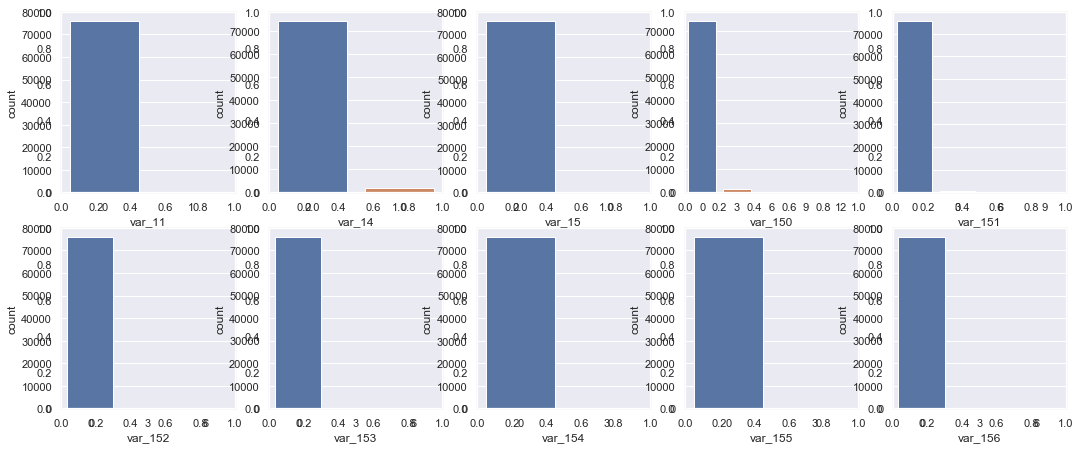

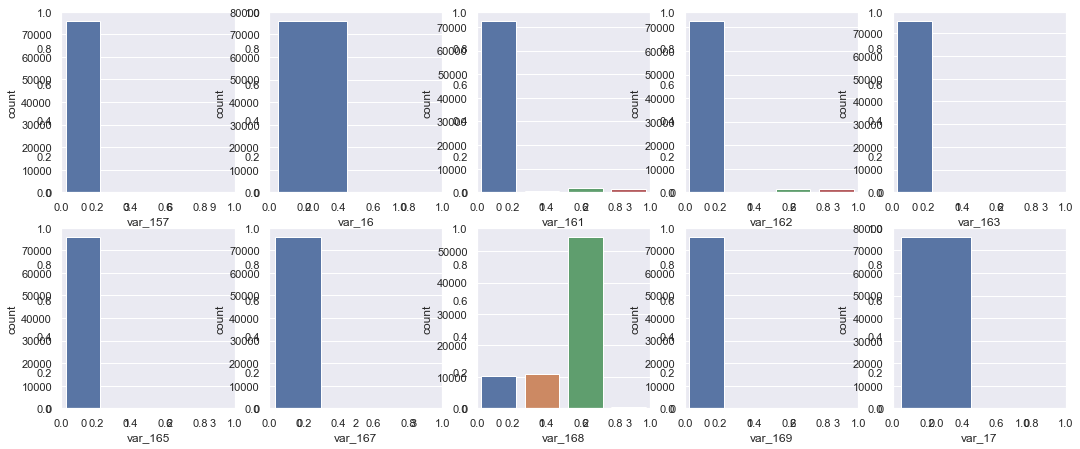

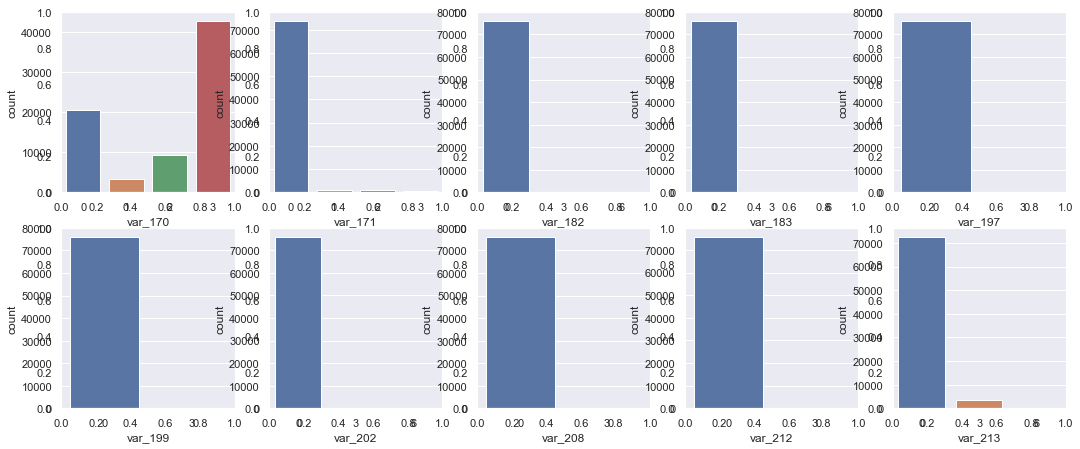

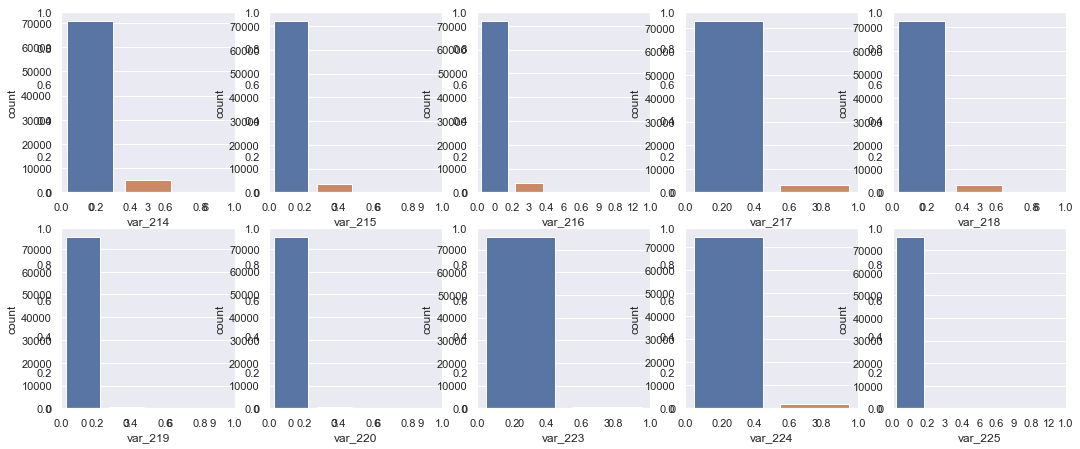

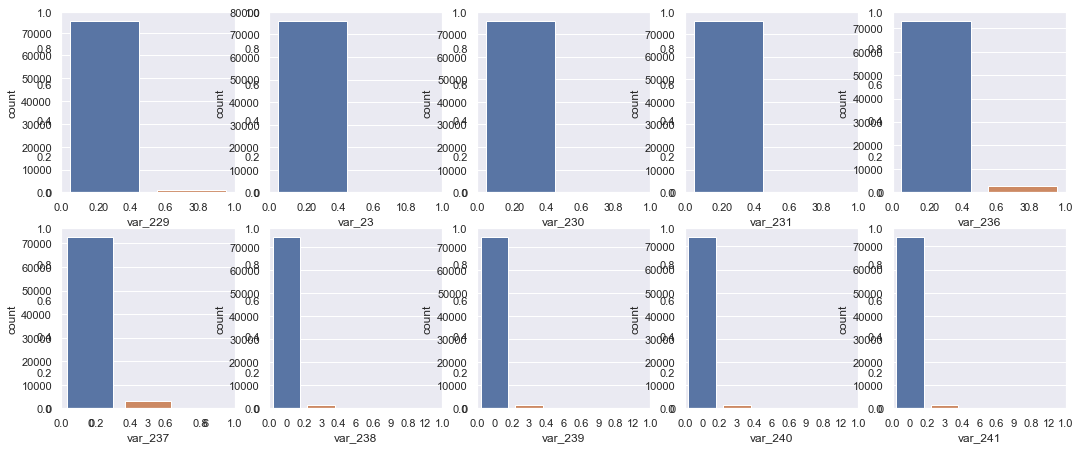

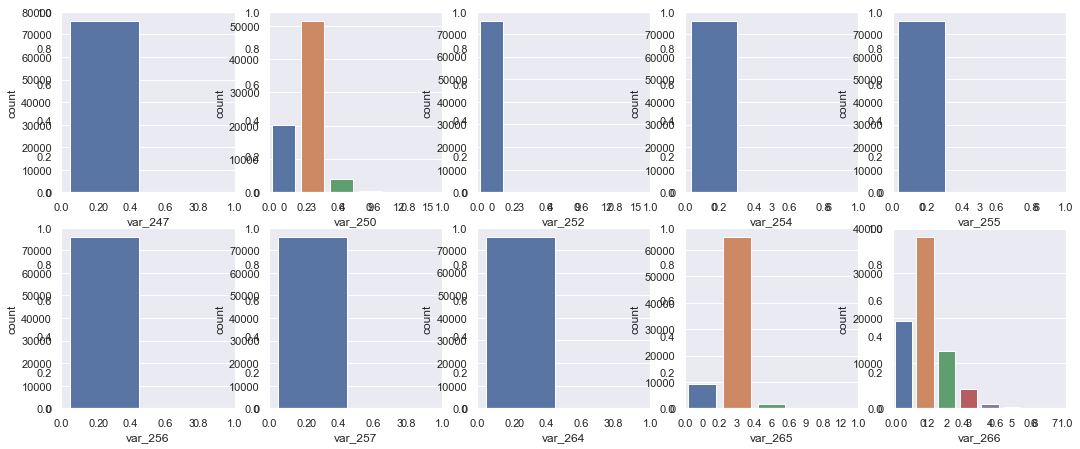

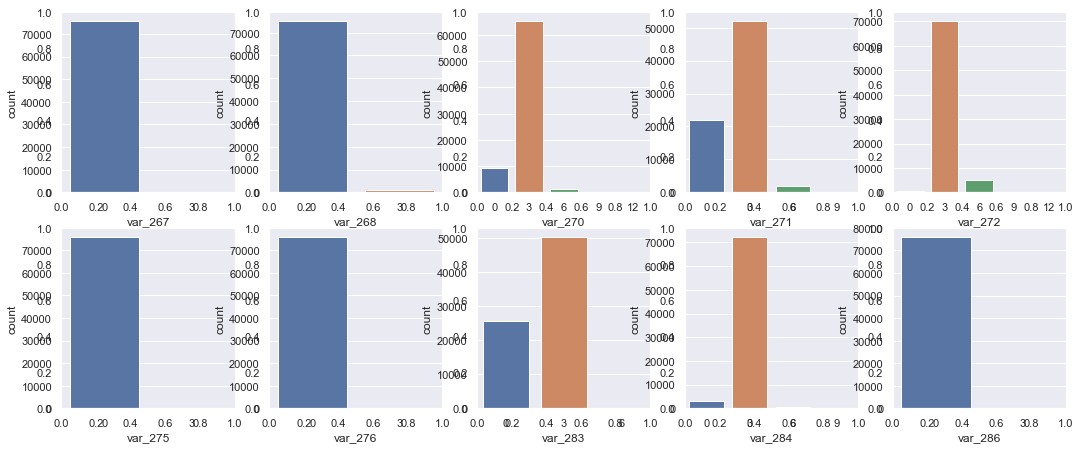

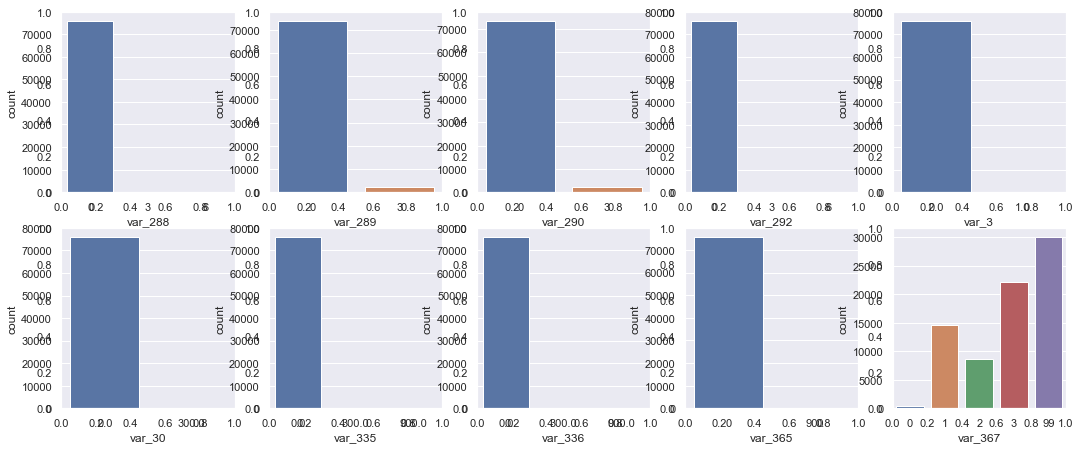

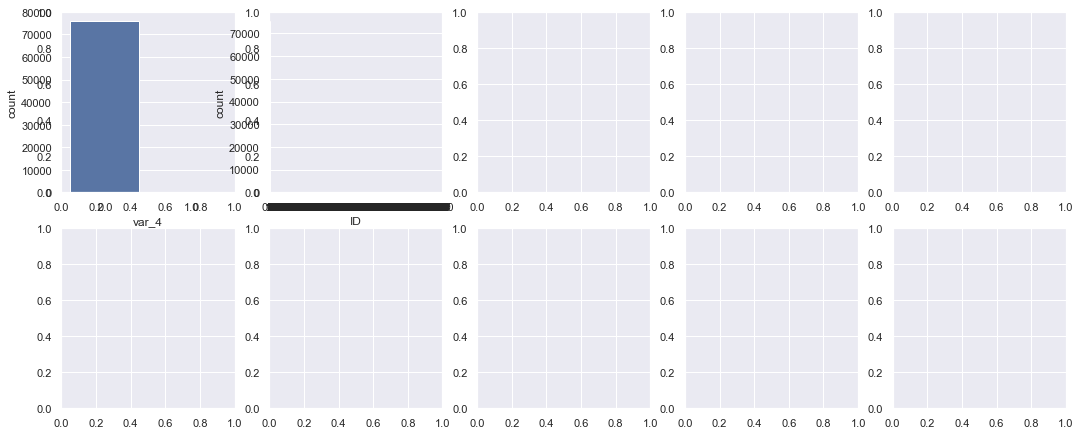

In [1052]:
## from the cleaned df; no zero values, no binary values [0,1]; cols with upto 5 categories
## (these charts are not exactly insightful)

col_list_ = split_features(df_cat_var.columns,10)
df_cat_ = pd.DataFrame()
col_subset_cat = list(col_list_)

for i in col_subset_cat:
    df_cat_ = df_cat_var[i] #ensure the right dataframe is used
    plot_categorical(df_cat_,i,2,5)

Method to obtain value counts and also identify those that occur only a certain number of times 
(Eg: several values may occur only 3 or 4 or 5 times; and the COUNT of such values are less than 100 or 500 in the total dataset)

In [1166]:
## count values that occur a certain number of times (specified by val_fr); threshold spcifies the total num of such values
global dict_count_occurence
dict_count_occurence = {}

def count_val_fr_replace(df_,val_fr,threshhold,val_replace,cat_num,dict_count_occurence):
    cols_updated = []
    for col in df_.columns:
        if col == 'ID':
            continue
        elif df_[col].nunique() <= cat_num:
            vc_ = df_[col].value_counts()          
            val_remove = vc_[vc_ <= val_fr].index.values # val_fr specifies the no. of times a value occurs
            dict_count_occurence.update({col:len(val_remove)})
            
            ## determine if the values need to be replaced with zero or the mean;
            if val_replace == 0:
                new_val = 0
            else:
                new_val = df_[col].mean()
            
            if (len(val_remove) <= threshhold):  # user specifed
                df_[col].loc[df_[col].isin(val_remove)] = new_val
                cols_updated.append(col)
                                
    print("cols_updated:",cols_updated)
                

In [1150]:
# Some additional processing
# checking for negative values in the df_cat_var dataset
cols_neg_val = df_cat_var.columns[(df_cat_var < 0).any()]
print(cols_neg_val)

for col in cols_neg_val:
    print(df_cat_var[col].value_counts())
    


Index([], dtype='object')


In [1114]:
# since the negative values are all -1 or small values b/n 0 and 1,and occur few times, replacing them with zero; (rest of th values are zero)
for col in cols_neg_val:
    df_cat_var[col].loc[df_cat_var[col] < 0] = 0

C:\Anaconda3\envs\ds19\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1115]:
# identify the next set of columns with all zero values
cols_zero_pass3 = df_cat_var.columns[(df_cat_var == 0).all()]
print(len(cols_zero_pass3))

# drop the cols with all zero values
df_cat_var.drop(columns=cols_zero_pass4,inplace=True)

8


C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1116]:
## remove columns with only binary data [0,1] in df_cat_var
cols_bin_val_pass2 = [col for col in df_cat_var.columns 
                         if np.isin(df_cat_var[col].unique(), [0, 1]).all()]

print(len(cols_bin_val_pass2))


9


In [1117]:
# RUN ONLY ONCE
# update list of cols with values binary only [0,1] 
cols_bin_only = cols_bin_only + cols_bin_val_pass2


In [1118]:
len(cols_bin_only)

76

In [1119]:
## save the file: 
df_cat_var.to_csv(r"df2_cat_var_5cat_clean.csv",index=False)

In [1123]:
# get columns with values 300 and 900 s
cols_300_900 = df_cat_var.columns[(df_cat_var == 300).any() | (df_cat_var == 900).any()]

for col in cols_300_900:
    print(df_cat_var[col].value_counts())

0.00      75784
900.00      236
Name: var_365, dtype: int64
0.00      76014
0.03          2
300.00        2
450.00        2
Name: var_35, dtype: int64
0.00      76018
300.00        2
Name: var_31, dtype: int64


In [1124]:
# since the values 300 and 900 occur few times and the resst of the values are zero, replacing them with zero
for i in cols_300_900: 
    df_cat_var[i].loc[(df_cat_var[i] == 300) | (df_cat_var[i] == 900)] = 0

C:\Anaconda3\envs\ds19\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1126]:
cols_zero_pass4 = df_cat_var.columns[(df_cat_var == 0).all()]
len(cols_zero_pass4)

10

In [1128]:
df_cat_var.drop(columns=cols_zero_pass4,inplace=True)

C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1129]:
df_cat_var.to_csv(r"df2_cat_var_final_CLEAN.csv",index=False)

Obtaining columns from the original dataset that were not included in the prior processing step; This still excludes columns with binary data

In [ ]:
# REMAINING COLUMNS - NON-CAT

In [1131]:
# columns without zeros, binary values
len(cols_incl)

270

In [1132]:
### remaining possible non-categorical columns:
# cols_incl -> no zero val cols, no binary vaues
# cols_cat -> output from the method identifying columns that have upto 5 data categories
# remaining cols: cols_incl - cols_cat

cols_rem = list(set(cols_incl) - set(cols_cat))

In [1133]:
len(cols_rem)

142

In [1134]:
global df_rem_data
df_rem_data = df[cols_rem]
cols_rem_zero = df_rem_data.columns[(df_rem_data == 0).all()]

## no more zero columns
len(cols_rem_zero)

0

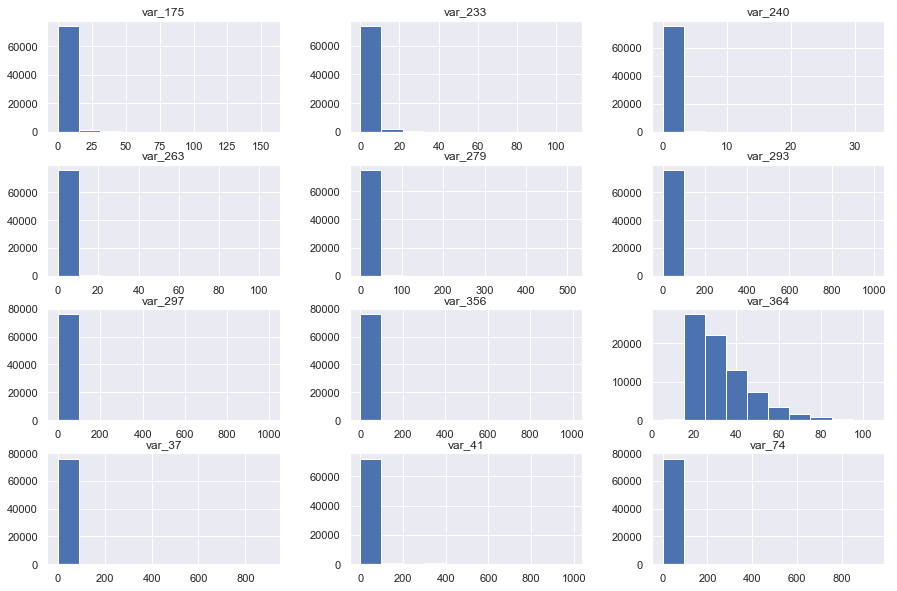

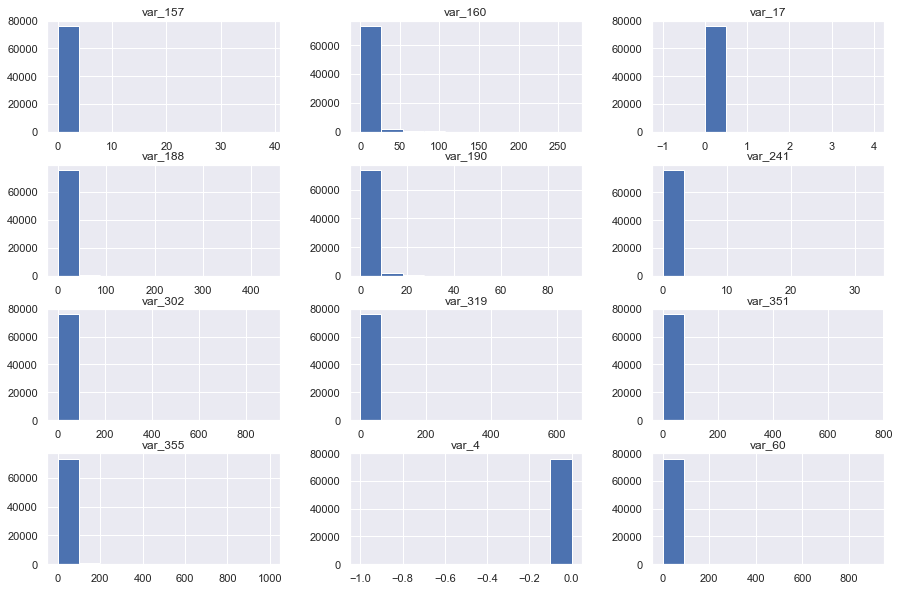

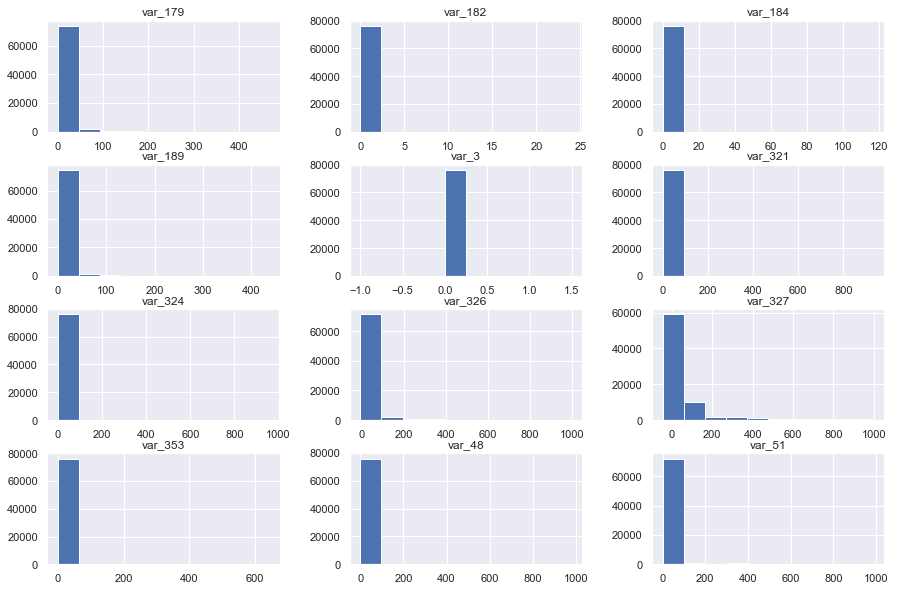

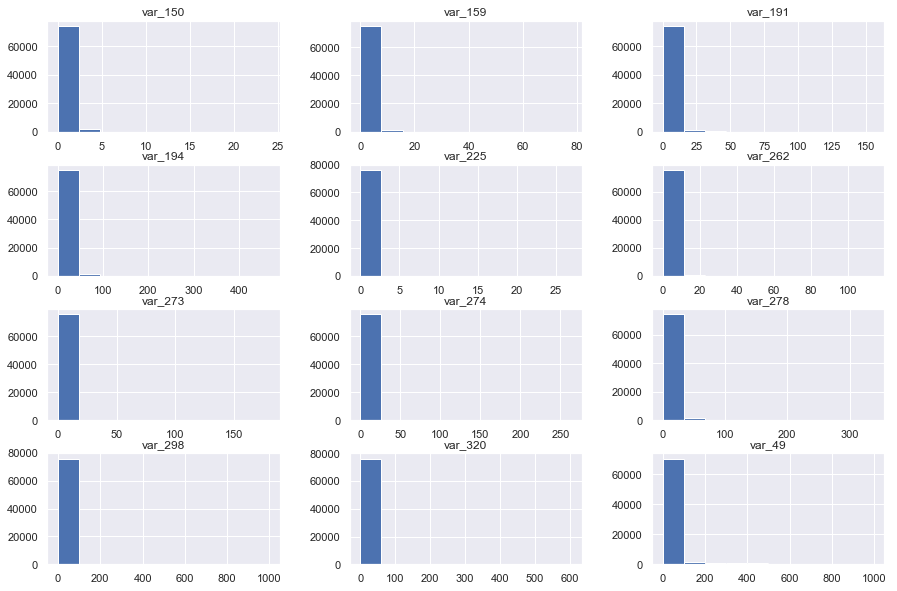

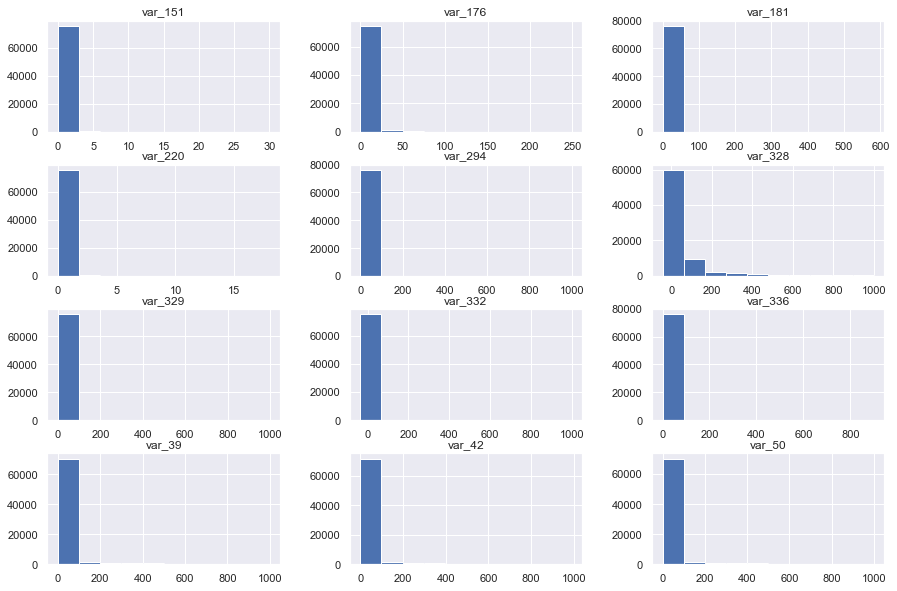

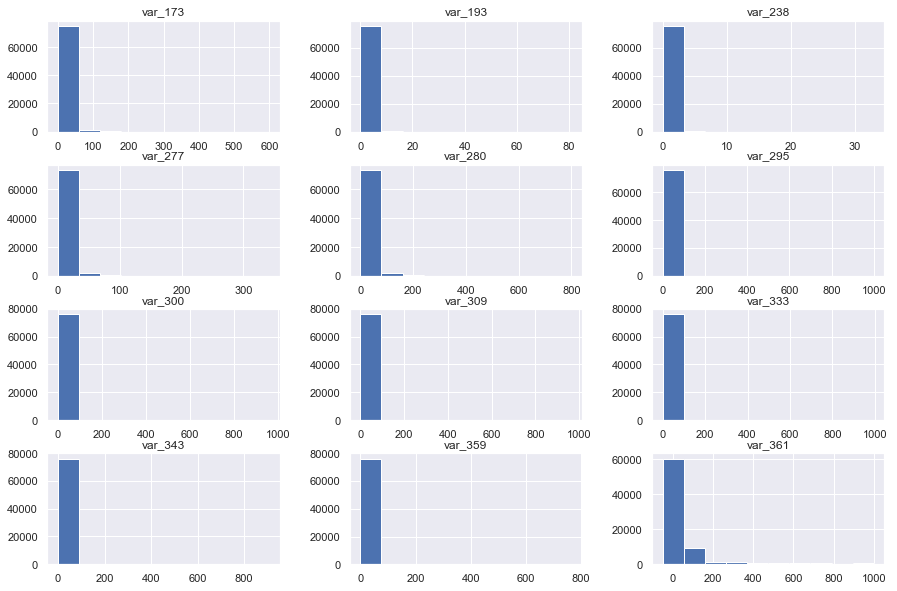

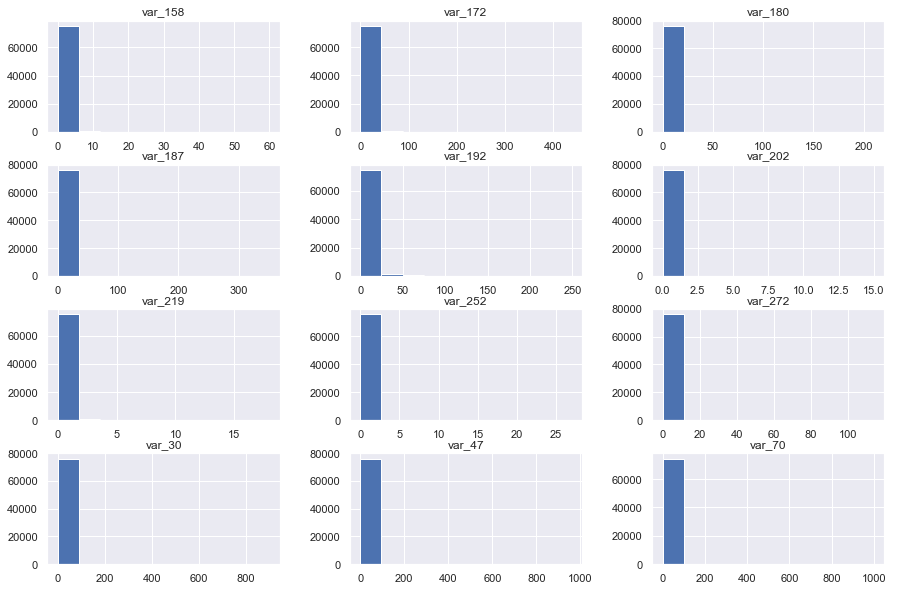

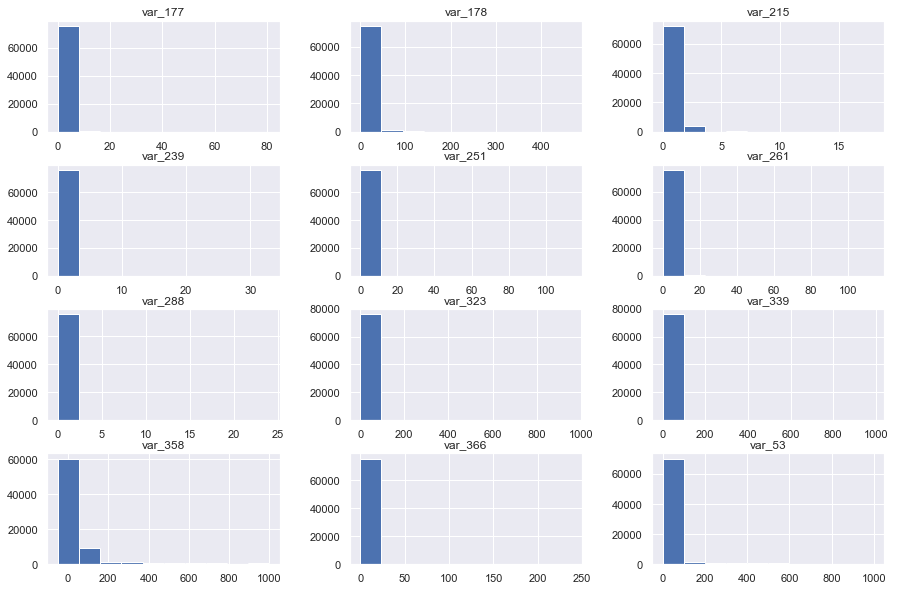

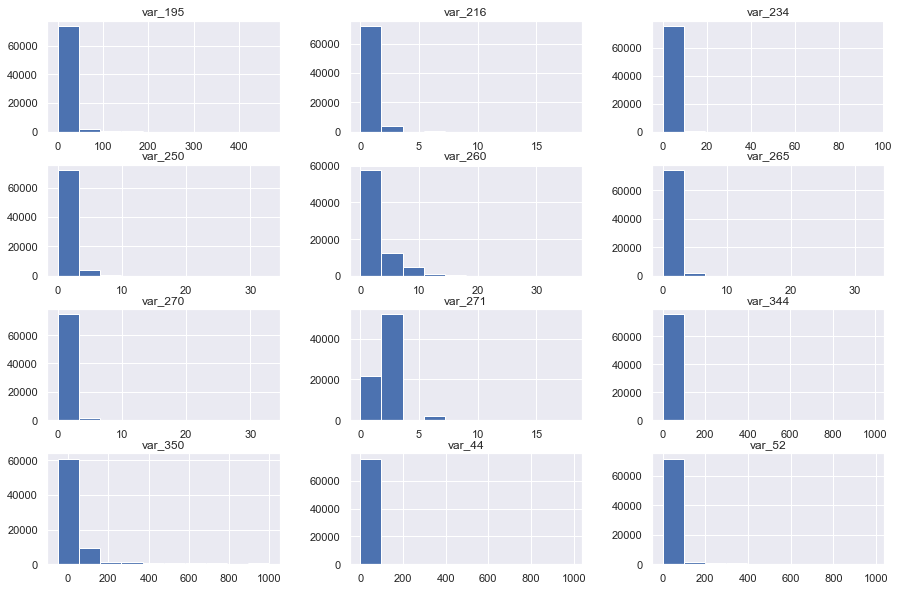

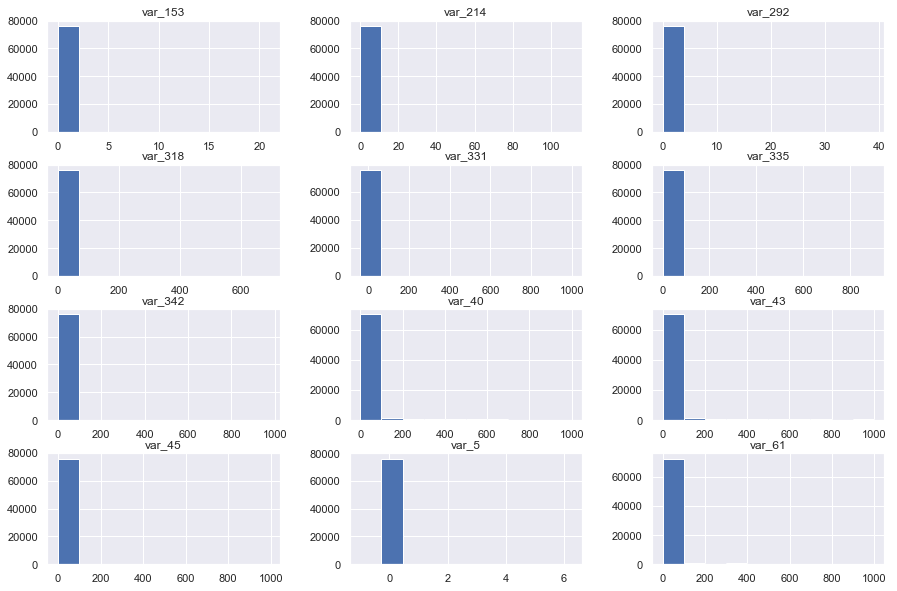

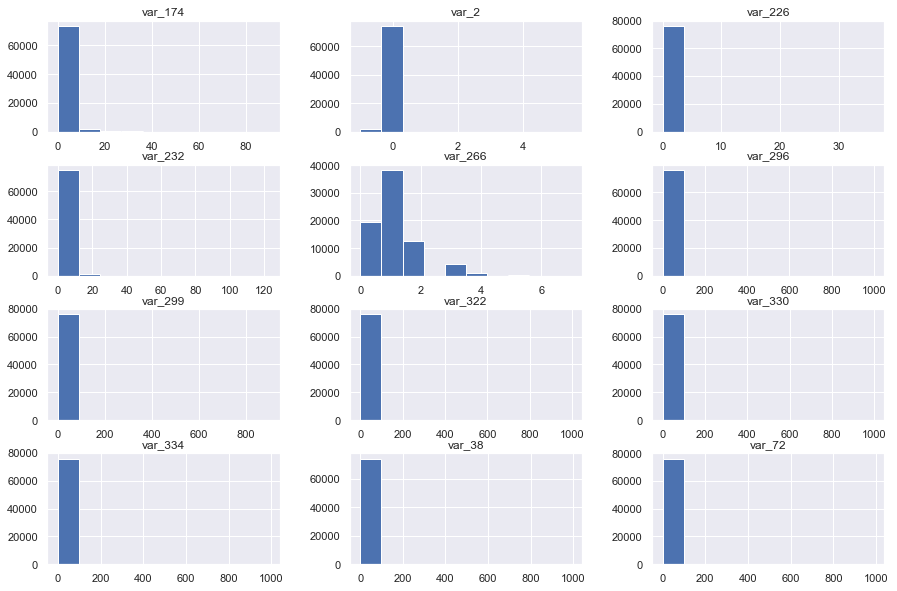

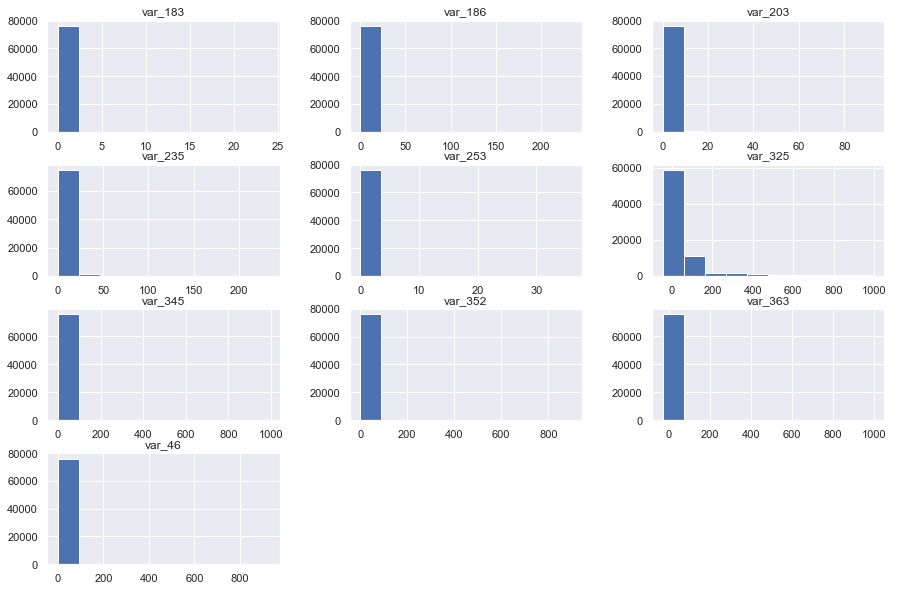

In [1135]:
# plt histogram of the remaining data -- data with more than 5 categories and contiuous data
col_list_rem = split_features(df_rem_data.columns,12)
df_rem_ = pd.DataFrame()
col_subset_rem = list(col_list_rem)

for i in col_subset_rem:
    df_rem_ = df_rem_data[i] #ensure the right dataframe is used
    df_rem_.hist(bins=10,figsize=(15,10))
    

In [1143]:
# count occurences of values that appear less than 15 times in the remaining columns; 
# useful to determine the threshold value for count_val_fr_replace() function
dict_rem_data = {}
for col in df_rem_data.columns:
    val_count = df_rem_data[col].value_counts()
    dict_rem_data.update({col:len(val_count[val_count <= 15].index.values)})

In [1138]:
dict_rem_data

{'var_150': 4,
 'var_151': 4,
 'var_153': 6,
 'var_157': 7,
 'var_158': 8,
 'var_159': 8,
 'var_160': 37,
 'var_17': 6,
 'var_172': 35,
 'var_173': 51,
 'var_174': 13,
 'var_175': 21,
 'var_176': 24,
 'var_177': 14,
 'var_178': 39,
 'var_179': 54,
 'var_180': 27,
 'var_181': 40,
 'var_182': 5,
 'var_183': 7,
 'var_184': 15,
 'var_186': 24,
 'var_187': 29,
 'var_188': 32,
 'var_189': 47,
 'var_190': 13,
 'var_191': 21,
 'var_192': 26,
 'var_193': 14,
 'var_194': 36,
 'var_195': 52,
 'var_2': 24,
 'var_202': 3,
 'var_203': 11,
 'var_214': 3,
 'var_215': 4,
 'var_216': 3,
 'var_219': 4,
 'var_220': 3,
 'var_225': 6,
 'var_226': 8,
 'var_232': 11,
 'var_233': 7,
 'var_234': 9,
 'var_235': 16,
 'var_238': 5,
 'var_239': 5,
 'var_240': 5,
 'var_241': 5,
 'var_250': 4,
 'var_251': 5,
 'var_252': 6,
 'var_253': 7,
 'var_260': 5,
 'var_261': 11,
 'var_262': 11,
 'var_263': 13,
 'var_265': 5,
 'var_266': 1,
 'var_270': 5,
 'var_271': 3,
 'var_272': 4,
 'var_273': 16,
 'var_274': 24,
 'var_277': 

In [1154]:
count_val_fr_replace

<function __main__.count_val_fr_replace(df_, val_fr, threshhold, val_replace, cat_num, dict_count_occurence)>

In [1167]:
dict_count_occurence.clear()
# find values that occur less than 15 times and replace them with zero, if such occurences are fewer than 500
count_val_fr_replace(df_rem_data,15,2000,0,15,dict_count_occurence)

C:\Anaconda3\envs\ds19\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cols_updated: ['var_240', 'var_37', 'var_74', 'var_4', 'var_319', 'var_157', 'var_17', 'var_302', 'var_241', 'var_353', 'var_182', 'var_3', 'var_159', 'var_150', 'var_225', 'var_320', 'var_336', 'var_151', 'var_220', 'var_359', 'var_238', 'var_309', 'var_272', 'var_158', 'var_219', 'var_202', 'var_252', 'var_30', 'var_288', 'var_239', 'var_215', 'var_251', 'var_265', 'var_271', 'var_216', 'var_260', 'var_250', 'var_270', 'var_318', 'var_292', 'var_153', 'var_335', 'var_214', 'var_322', 'var_266', 'var_226', 'var_352', 'var_183', 'var_253']


In [1168]:
# after further cleaning, check for columns with all zero values

cols_rem_zero_pass1 = df_rem_data.columns[(df_rem_data == 0).all()]
len(cols_rem_zero_pass1)

11

In [1169]:
# drop columns with zero values:
df_rem_data.drop(columns=cols_rem_zero_pass1,inplace=True)

C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1170]:
len(df_rem_data.columns)

131

In [1171]:
# write to file:
df_rem_data.to_csv(r"df2_rem_data_pass1.csv",index=False)

In [1172]:
# identify columsn with negative values
cols_rem_neg = df_rem_data.columns[(df_rem_data < 0).any()]
len(cols_rem_neg)

17

In [1173]:
# quickly check for the occurences of the negative values before removing them 
for col in cols_rem_neg:
    vc_neg = df_rem_data[col].value_counts()
    print("col:",col,"occurences:", vc_neg[vc_neg.index.values < 0])
    


col: var_356 occurences: -0.90    1
Name: var_356, dtype: int64
col: var_4 occurences: -1.00    17
Name: var_4, dtype: int64
col: var_17 occurences: -1.00    18
Name: var_17, dtype: int64
col: var_326 occurences: -8.04    1
-4.77    1
-5.31    1
-6.09    1
Name: var_326, dtype: int64
col: var_3 occurences: -1.00    17
Name: var_3, dtype: int64
col: var_327 occurences: -2.01     2
-0.09     2
-16.95    2
-1.50     1
-27.09    1
-19.50    1
-1.80     1
-4.89     1
-9.96     1
-6.60     1
-0.12     1
-45.06    1
-36.03    1
-5.25     1
-27.42    1
-24.06    1
-36.66    1
-36.15    1
-45.45    1
-19.23    1
-1.29     1
-8.37     1
-41.16    1
-12.87    1
-15.00    1
-13.98    1
-19.47    1
-9.33     1
-7.47     1
-9.54     1
-25.08    1
-5.13     1
-2.94     1
Name: var_327, dtype: int64
col: var_328 occurences: -4.71     1
-1.92     1
-7.89     1
-42.63    1
-5.46     1
-5.19     1
-35.16    1
-5.76     1
-18.45    1
-6.90     1
-18.84    1
-33.33    1
-31.38    1
-1.23     1
-2.52     1


C:\Anaconda3\envs\ds19\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [ ]:
# based on previous output, if such occurences are few (say less than 200), replace them with zero
# (not using mean here, since some mean values are negative)
for col in cols_rem_neg:
    df_rem_data[col].loc[df_rem_data[col] < 0] = 0
    

In [1174]:
len(df_rem_data.columns)

131

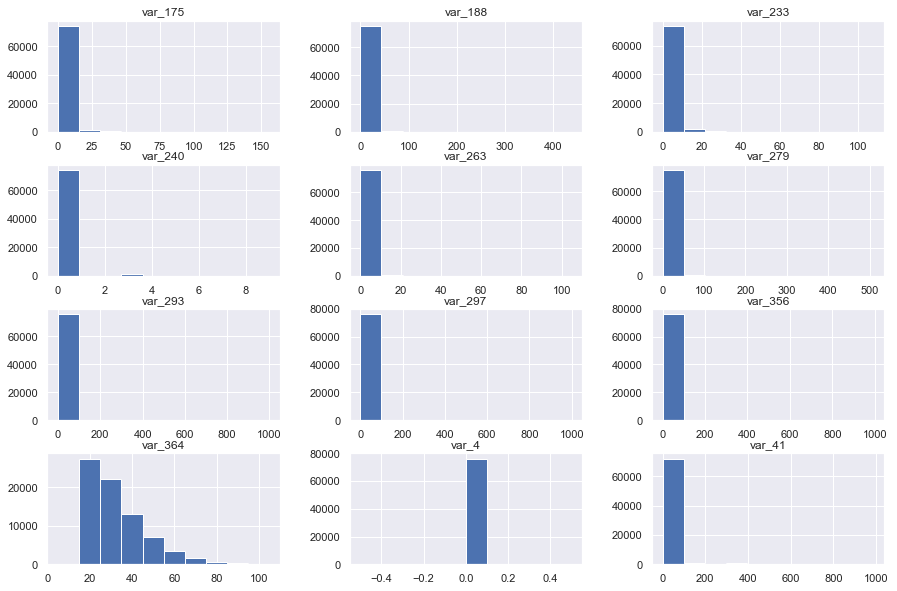

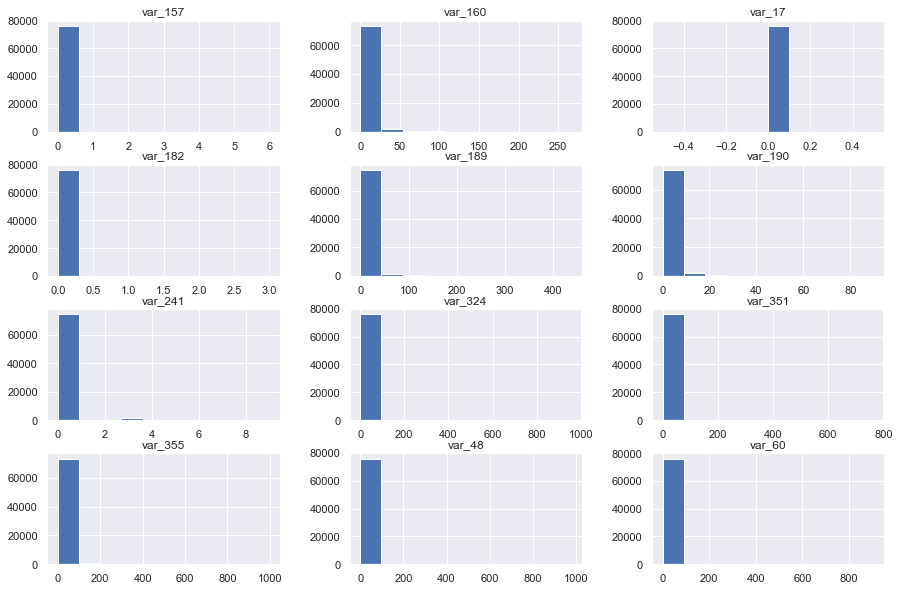

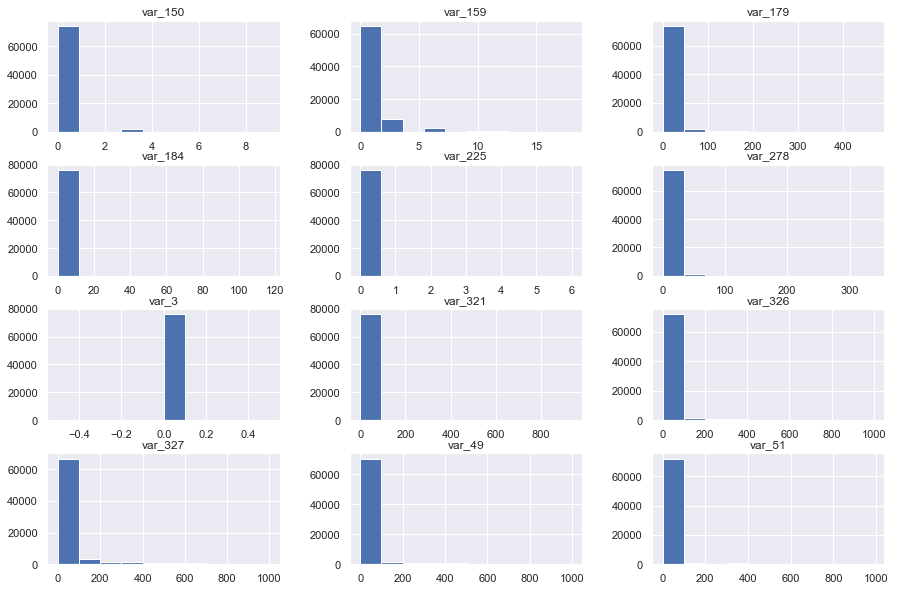

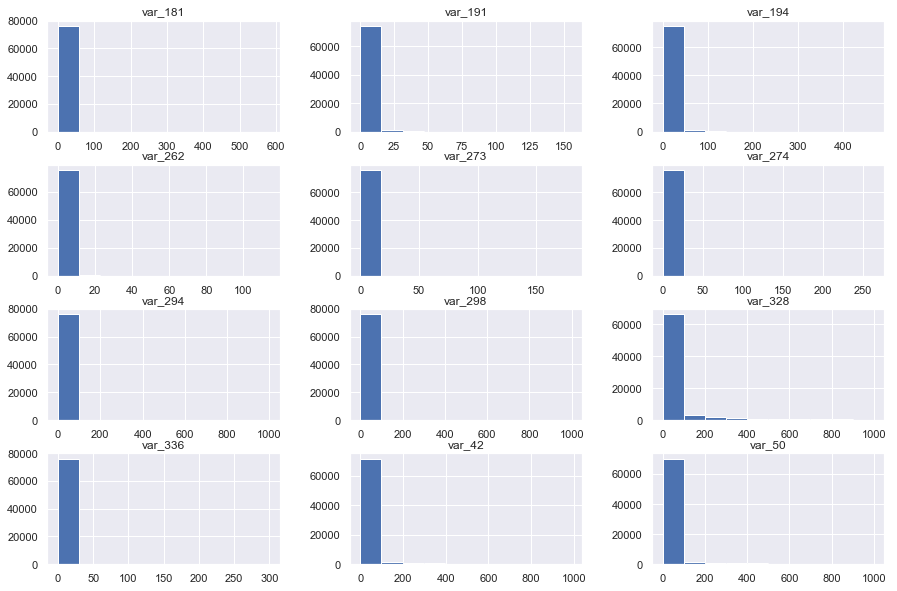

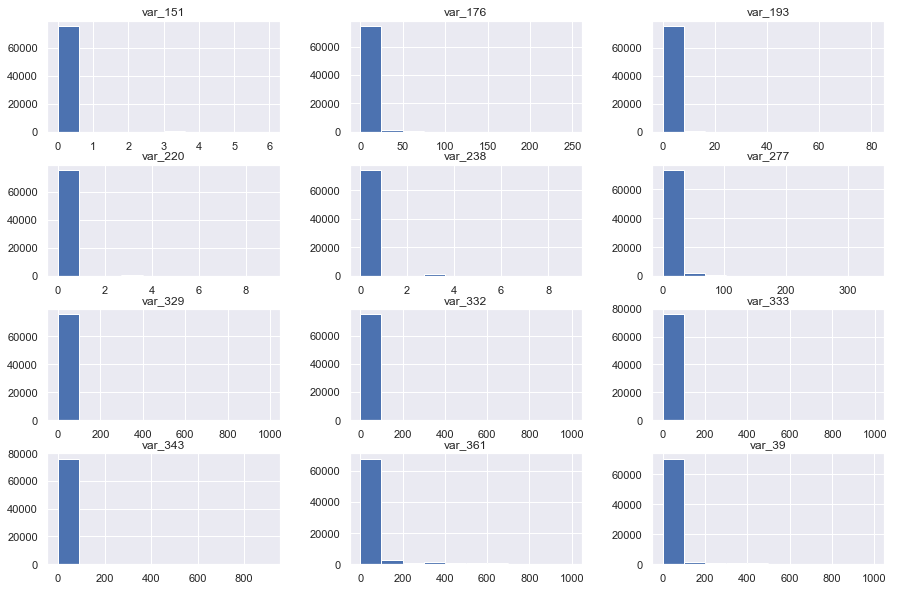

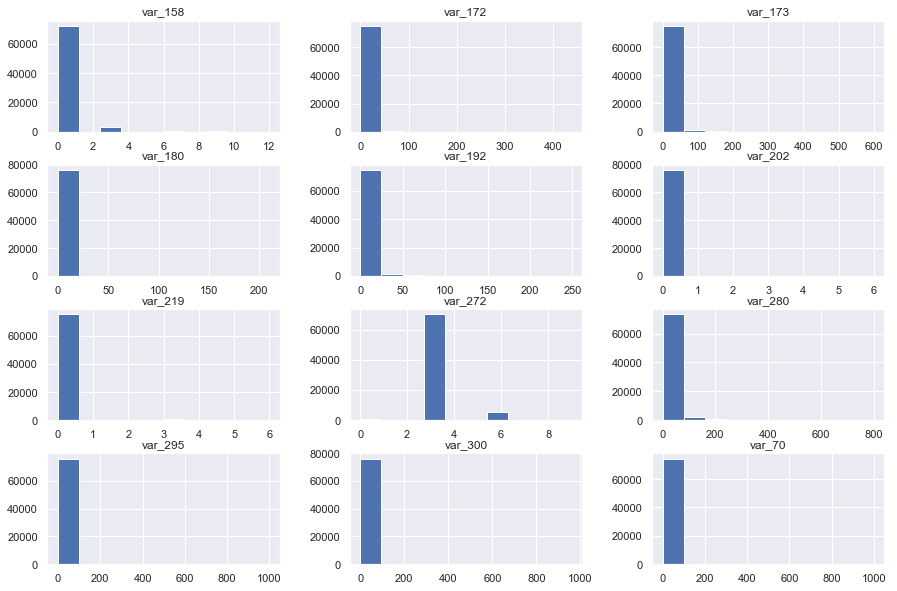

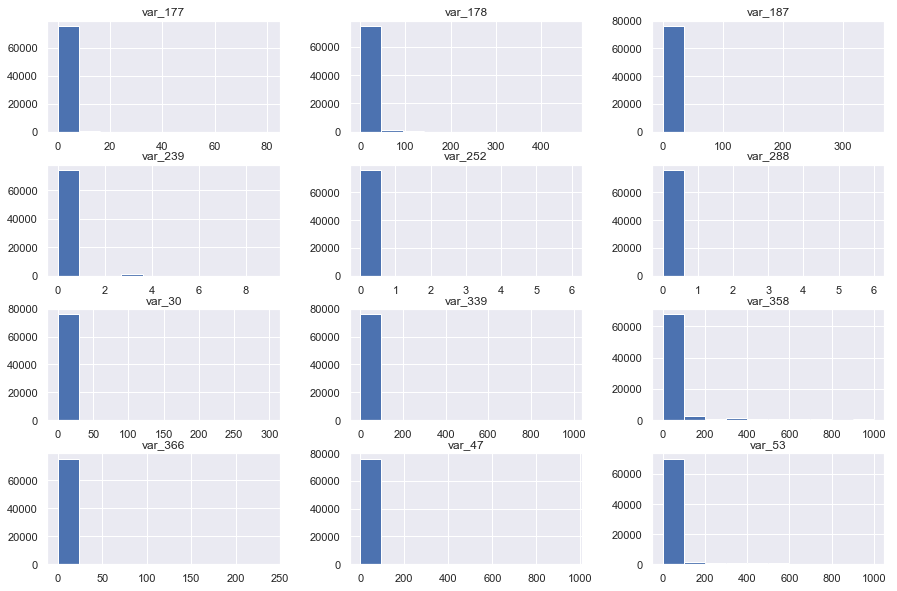

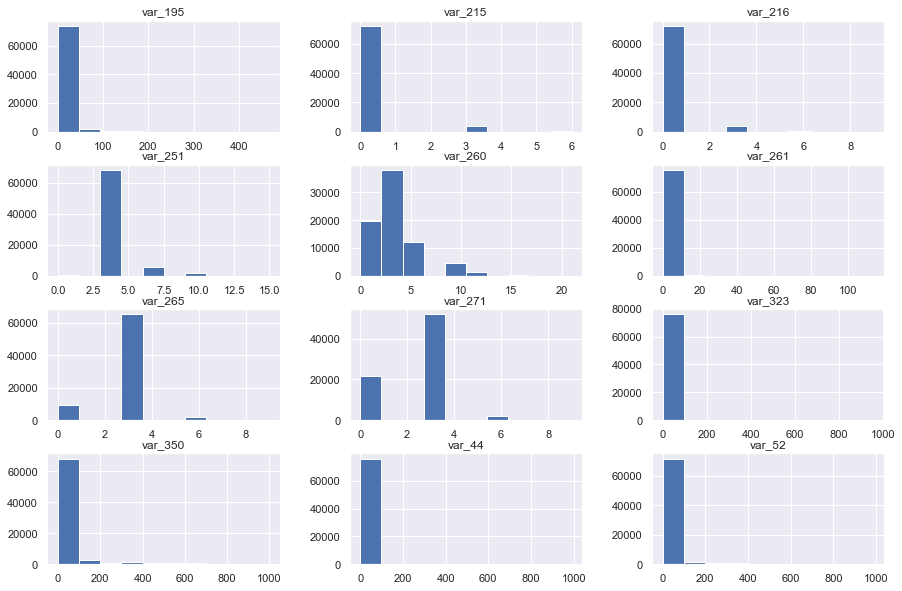

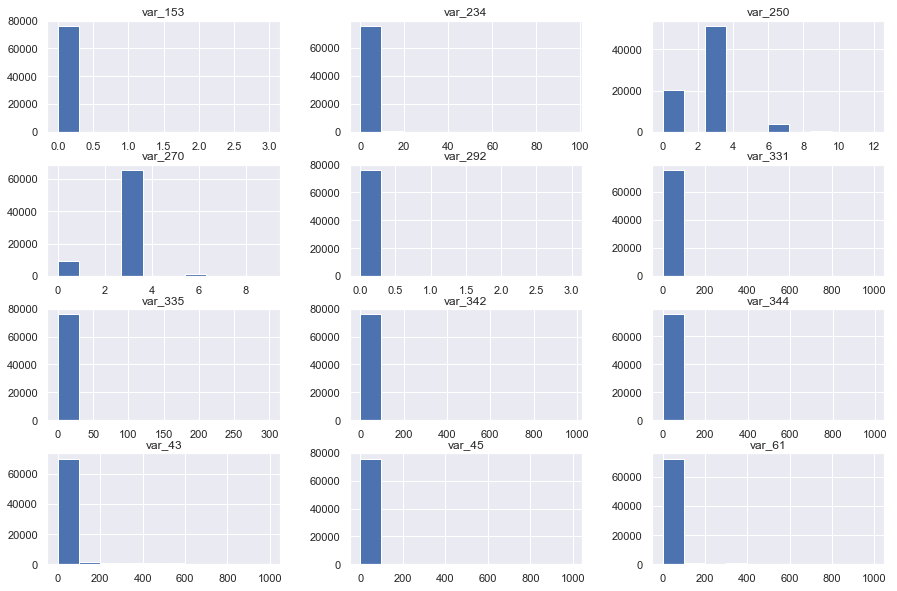

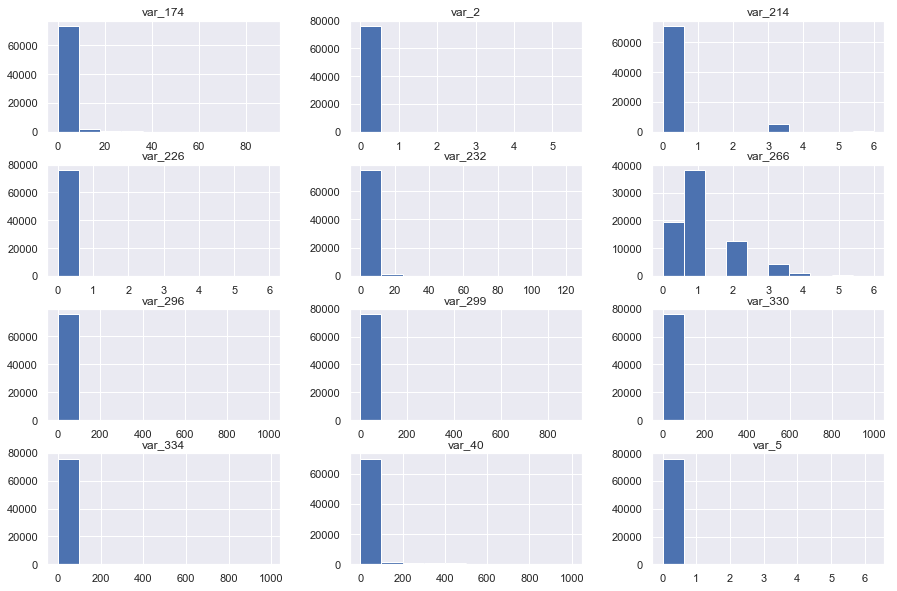

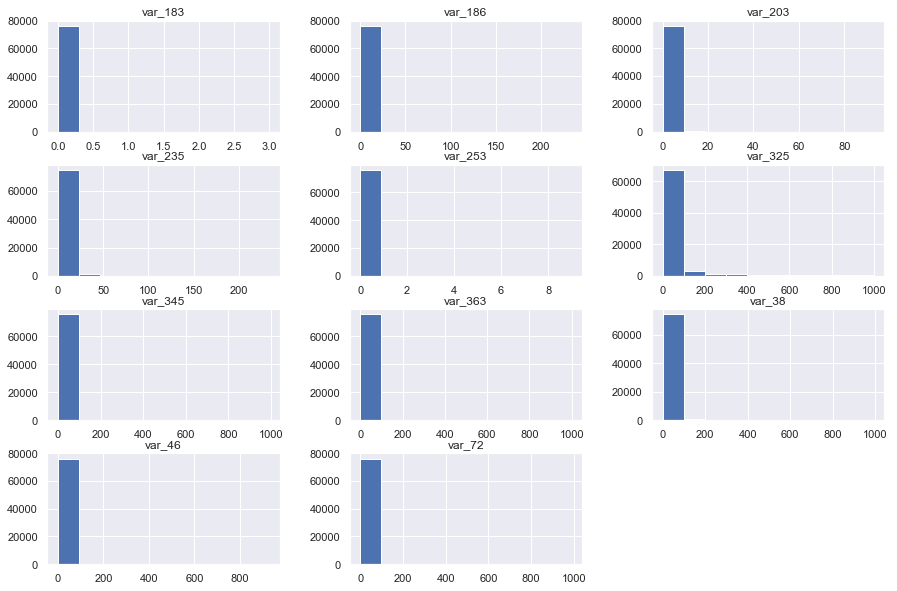

In [1175]:
# plot histogram on the cleaned remaining data

col_rem_clean = split_features(df_rem_data.columns,12)
df_rem_clean = pd.DataFrame()
col_subset_rem_clean = list(col_rem_clean)

for i in col_subset_rem_clean:
    df_rem_clean = df_rem_data[i] #ensure the right dataframe is used
    df_rem_clean.hist(bins=10,figsize=(15,10))
    

In [1176]:
count_val_fr_replace

<function __main__.count_val_fr_replace(df_, val_fr, threshhold, val_replace, cat_num, dict_count_occurence)>

In [1177]:
# the histogram above suggests that there is still some data/columns that have values that occur only once
# second pass on removing values that occur only once; and the count of such values is less than 10*100

count_val_fr_replace(df_rem_data,1,100,0,10,dict_count_occurence)

C:\Anaconda3\envs\ds19\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cols_updated: ['var_240', 'var_4', 'var_157', 'var_17', 'var_241', 'var_182', 'var_3', 'var_159', 'var_150', 'var_225', 'var_336', 'var_151', 'var_220', 'var_238', 'var_272', 'var_158', 'var_219', 'var_202', 'var_252', 'var_30', 'var_288', 'var_239', 'var_215', 'var_251', 'var_265', 'var_271', 'var_216', 'var_260', 'var_250', 'var_270', 'var_292', 'var_153', 'var_335', 'var_214', 'var_5', 'var_266', 'var_226', 'var_183', 'var_253']


In [1178]:
# after processing, get all columns that have all zero values
cols_rem_zero_pass2 = df_rem_data.columns[(df_rem_data == 0).all()]
len(cols_rem_zero_pass2)

4

In [1179]:
## drop the zero columns
df_rem_data.drop(columns=cols_rem_zero_pass2,inplace=True)
len(df_rem_data.columns)

C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


127

In [1185]:
# In the remaining dataset, identify columns that may have categorical data (<=5)

cols_rem_data_cat = []
for col in df_rem_data.columns:
    if (df_rem_data[col].nunique() <=5):
        cols_rem_data_cat.append(col)

print(cols_rem_data_cat)
len(cols_rem_data_cat)

['var_240', 'var_157', 'var_241', 'var_182', 'var_150', 'var_225', 'var_336', 'var_151', 'var_220', 'var_238', 'var_272', 'var_158', 'var_219', 'var_202', 'var_252', 'var_30', 'var_288', 'var_239', 'var_215', 'var_265', 'var_271', 'var_216', 'var_250', 'var_270', 'var_292', 'var_153', 'var_335', 'var_214', 'var_226', 'var_183', 'var_253']


31

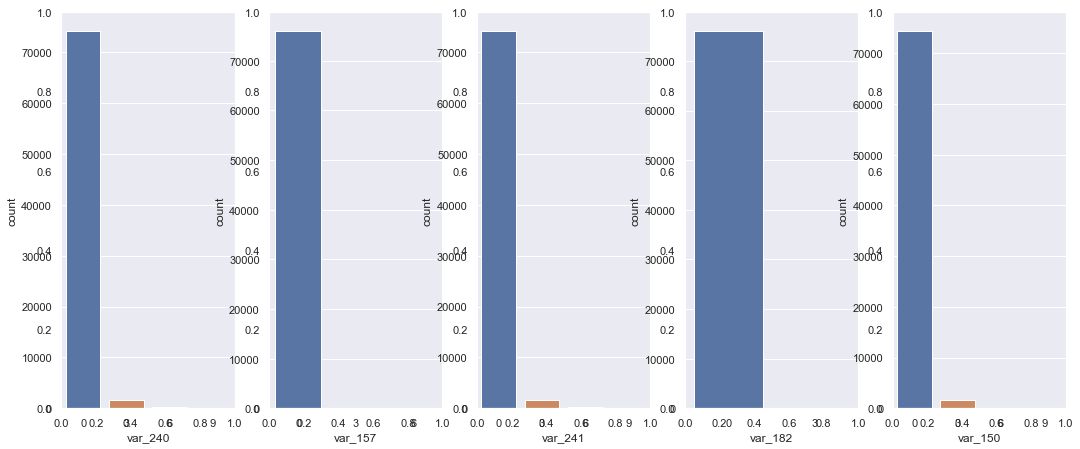

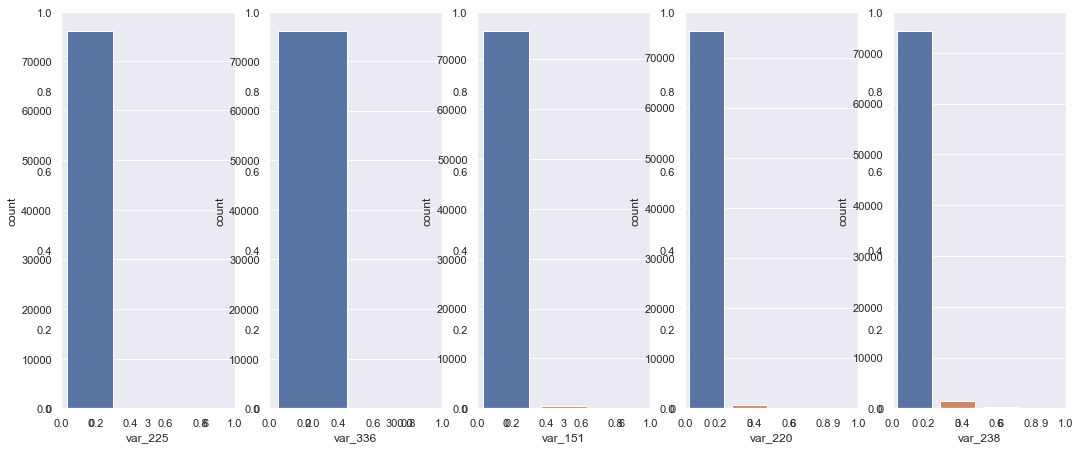

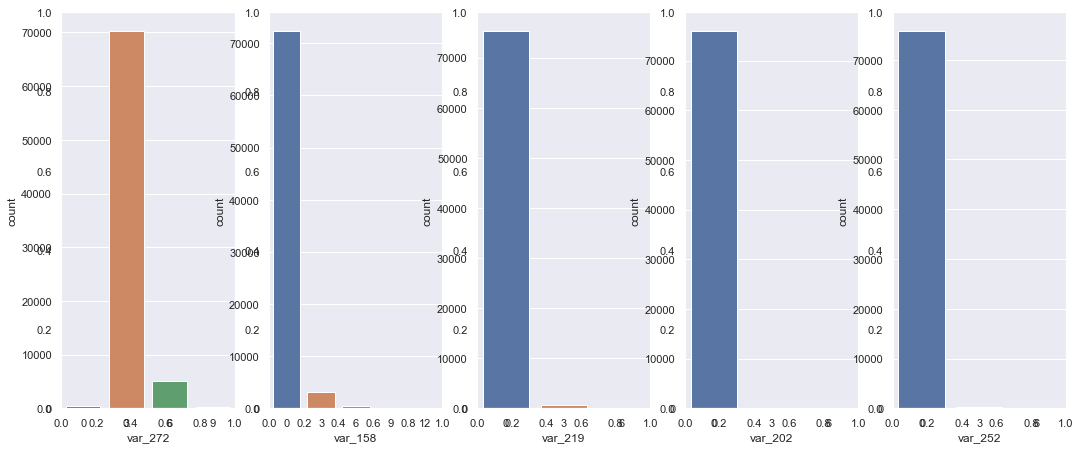

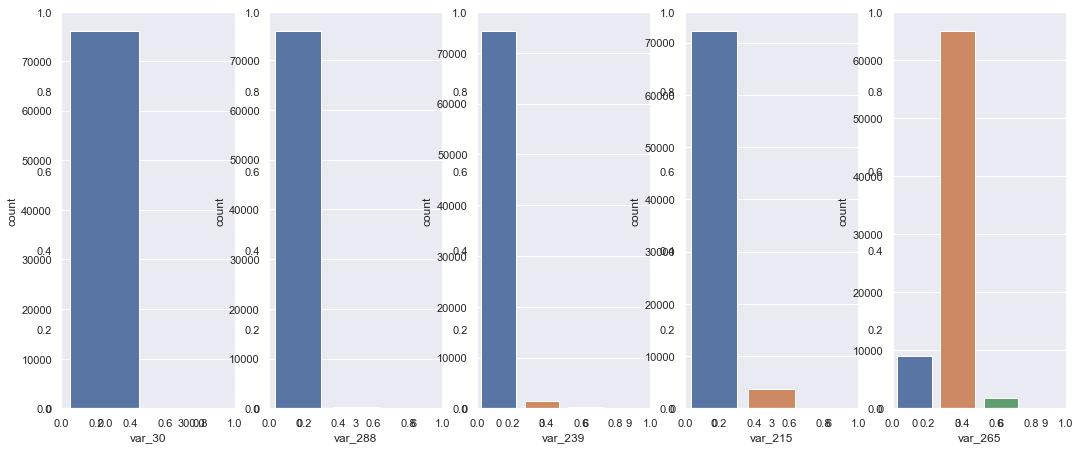

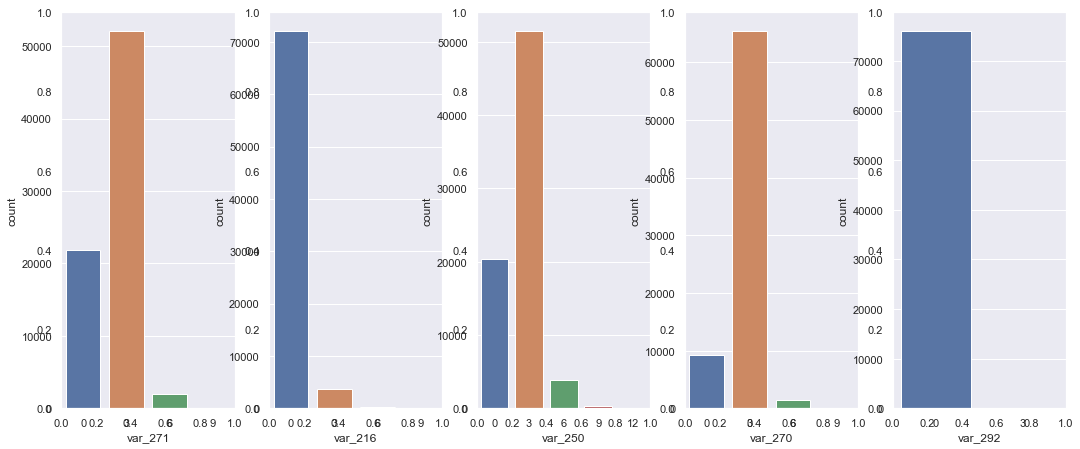

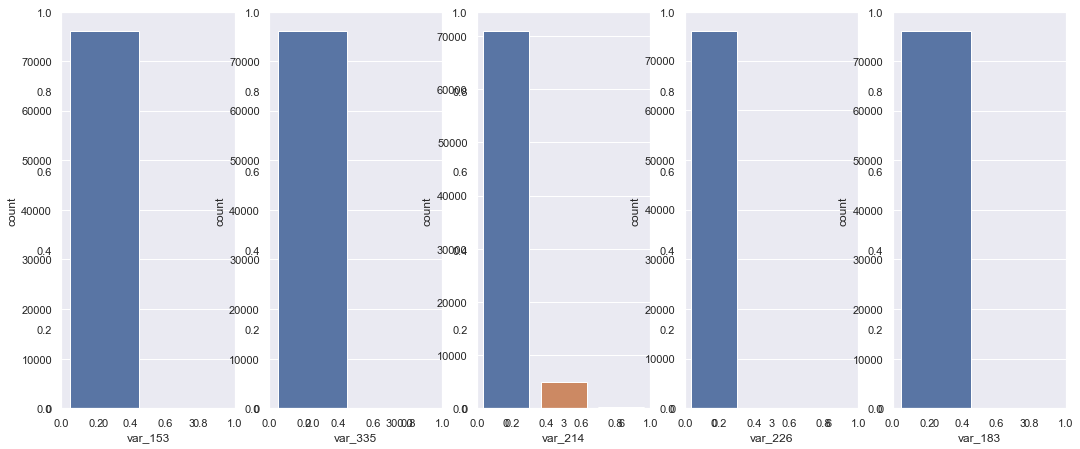

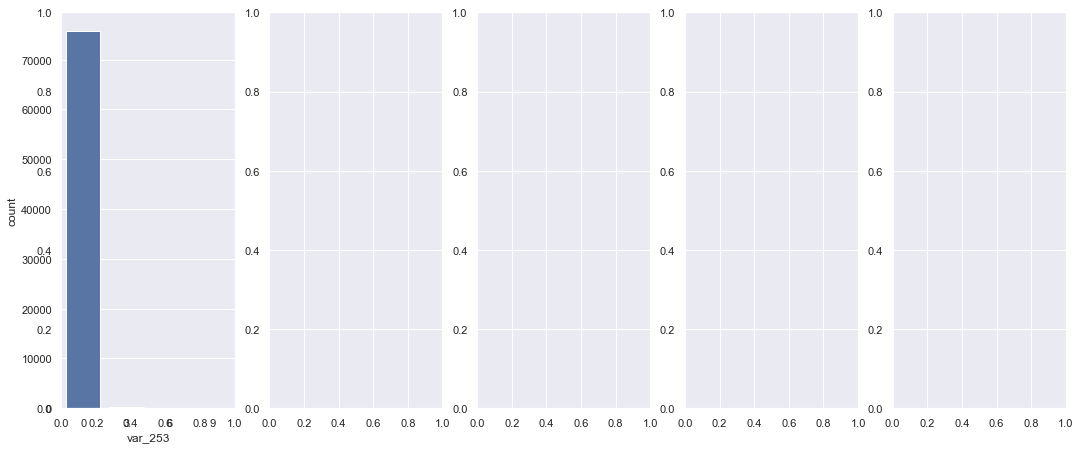

In [1186]:

col_rem_cat = split_features(cols_rem_data_cat,5)
df_rem_cat = pd.DataFrame()
col_subset_rem_cat = list(col_rem_cat)

for i in col_subset_rem_cat:
    df_rem_cat = df_rem_data[i] #ensure the right dataframe is used
    plot_categorical(df_rem_cat,i,1,5)

In [1188]:
## look for values that appear only twice and replace such occurences with the mean
count_val_fr_replace(df_rem_data,2,100,0,15,dict_count_occurence)

C:\Anaconda3\envs\ds19\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cols_updated: ['var_240', 'var_157', 'var_241', 'var_182', 'var_159', 'var_150', 'var_225', 'var_336', 'var_151', 'var_220', 'var_238', 'var_272', 'var_158', 'var_219', 'var_202', 'var_252', 'var_30', 'var_288', 'var_239', 'var_215', 'var_251', 'var_265', 'var_271', 'var_216', 'var_260', 'var_250', 'var_270', 'var_292', 'var_153', 'var_335', 'var_214', 'var_2', 'var_266', 'var_226', 'var_183', 'var_253']


In [1189]:
# after processing, get all columns that have all zero values
cols_rem_zero_pass3 = df_rem_data.columns[(df_rem_data == 0).all()]
len(cols_rem_zero_pass3)

1

In [1190]:
# after processing, get all columns that have all zero values
cols_rem_zero_pass3 = df_rem_data.columns[(df_rem_data == 0).all()]
len(cols_rem_zero_pass3)



1

In [1197]:
df_rem_data.describe()

,var_279,var_364,var_356,var_297,var_41,var_293,var_233,var_240,var_175,var_263,var_188,var_160,var_157,var_355,var_60,var_190,var_241,var_351,var_48,var_189,var_182,var_324,var_51,var_179,var_326,var_327,var_321,var_184,var_159,var_150,var_278,var_49,var_225,var_274,var_273,var_298,var_194,var_191,var_262,var_50,var_328,var_294,var_336,var_42,var_181,var_332,var_329,var_176,var_151,var_39,var_220,var_343,var_333,var_277,var_238,var_193,var_361,var_295,var_300,var_280,...,var_192,var_70,var_47,var_252,var_30,var_187,var_288,var_53,var_177,var_178,var_358,var_339,var_239,var_366,var_215,var_261,var_251,var_323,var_265,var_195,var_271,var_216,var_260,var_52,var_350,var_44,var_250,var_344,var_234,var_270,var_45,var_292,var_61,var_331,var_153,var_342,var_43,var_335,var_214,var_40,var_330,var_2,var_334,var_174,var_266,var_296,var_226,var_232,var_299,var_38,var_72,var_203,var_46,var_183,var_325,var_235,var_253,var_345,var_186,var_363
count,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,...,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00
mean,4.36,33.21,1.03,0.48,22.07,1.30,1.18,0.09,1.22,0.26,2.12,4.02,0.00,13.66,0.17,0.72,0.09,0.09,0.97,3.46,0.00,0.06,22.01,4.63,26.12,58.66,0.07,0.02,0.63,0.07,3.89,31.25,0.00,0.81,0.39,0.65,2.86,1.21,0.42,34.41,57.75,1.02,0.13,25.64,0.14,5.14,2.95,1.62,0.02,31.78,0.04,0.27,1.03,5.39,0.08,0.09,52.93,1.28,0.30,13.65,...,1.60,10.27,0.20,0.01,0.09,0.08,0.01,35.19,0.09,2.92,54.30,0.47,0.08,2.71,0.16,0.42,3.37,0.07,2.72,4.55,2.22,0.17,3.29,25.55,52.03,1.07,2.38,2.64,0.56,2.70,1.06,0.00,21.88,4.55,0.00,0.44,35.72,0.13,0.21,34.68,0.87,0.00,1.14,0.72,1.08,1.50,0.01,1.30,0.33,11.18,0.36,0.12,0.18,0.00,56.14,3.04,0.01,2.73,0.06,3.31
std,14.41,12.96,25.60,16.74,106.45,27.99,3.26,0.58,5.18,1.65,8.80,10.93,0.12,79.38,9.83,3.21,0.58,6.91,25.01,14.14,0.06,6.14,106.23,17.18,94.54,151.95,7.37,0.90,1.75,0.50,10.42,124.82,0.14,3.56,2.22,21.23,10.89,5.16,2.24,132.60,150.27,24.41,6.15,114.71,4.29,55.91,41.26,7.39,0.23,126.08,0.38,12.77,25.60,14.50,0.56,1.22,144.82,27.61,12.09,33.30,...,7.32,76.84,11.80,0.20,5.22,2.56,0.18,136.25,1.23,11.11,147.82,16.33,0.56,9.45,0.69,2.24,1.27,6.56,1.12,16.89,1.49,0.73,2.85,114.44,144.94,24.83,1.63,42.59,2.10,1.09,25.64,0.05,111.57,52.73,0.05,16.31,137.42,6.15,0.79,133.24,20.74,0.00,26.01,3.23,0.91,30.32,0.15,3.45,13.12,79.11,15.16,1.17,11.05,0.05,144.61,6.21,0.26,43.25,1.83,45.08
min,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,23.00,0.00,0.00,0.00,0.00,0.00,0.00

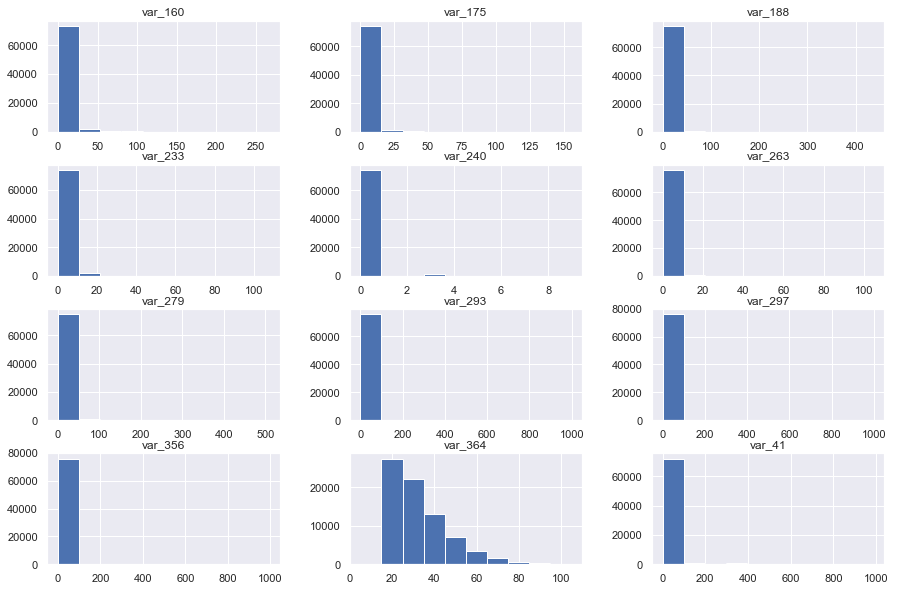

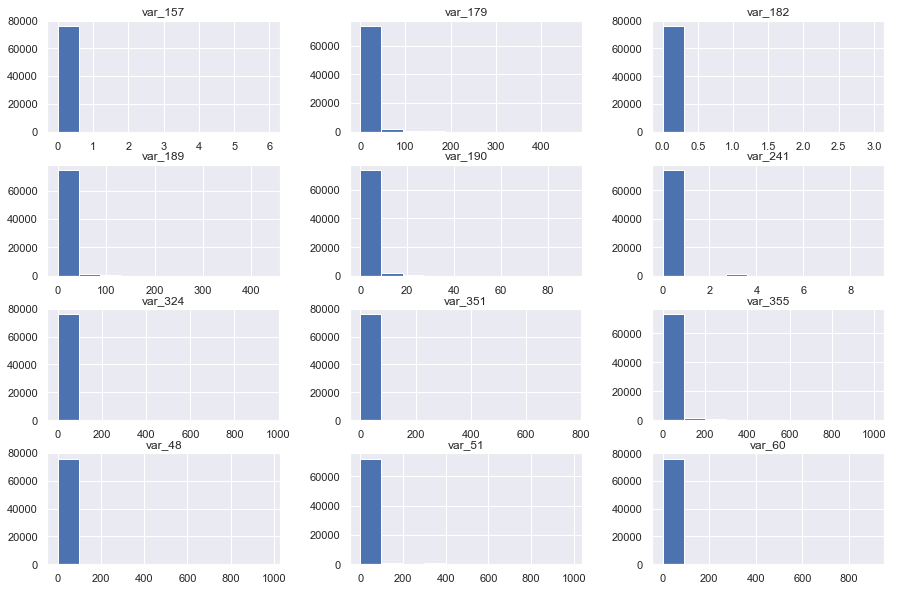

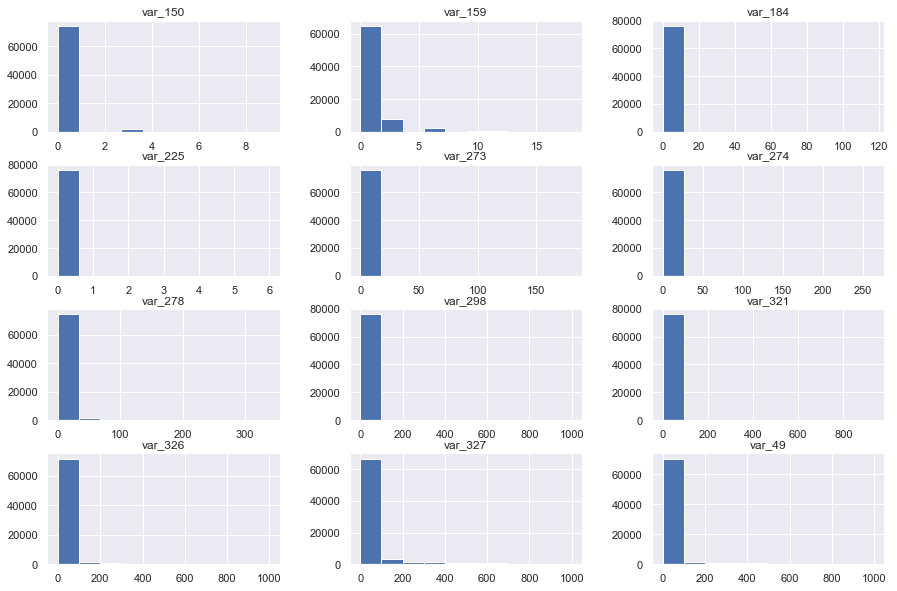

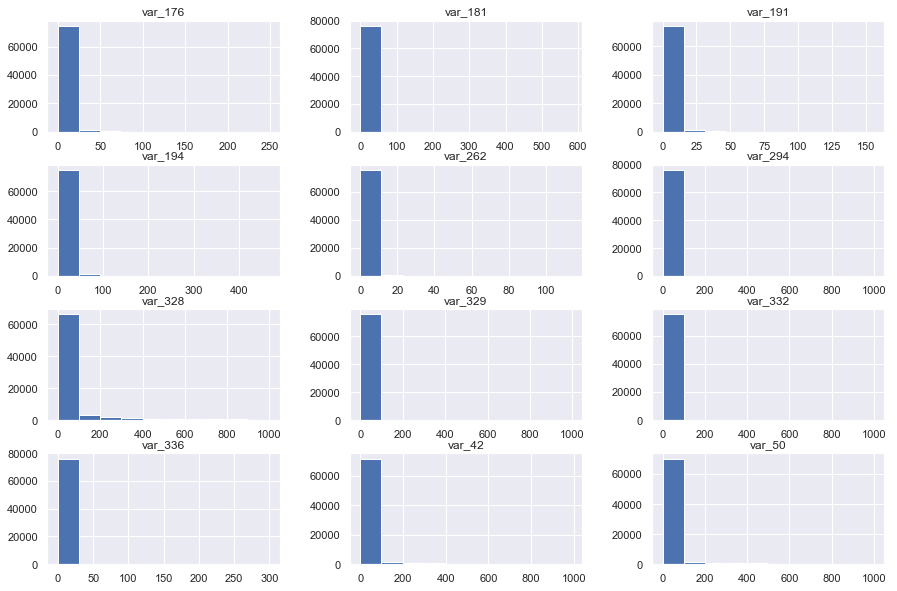

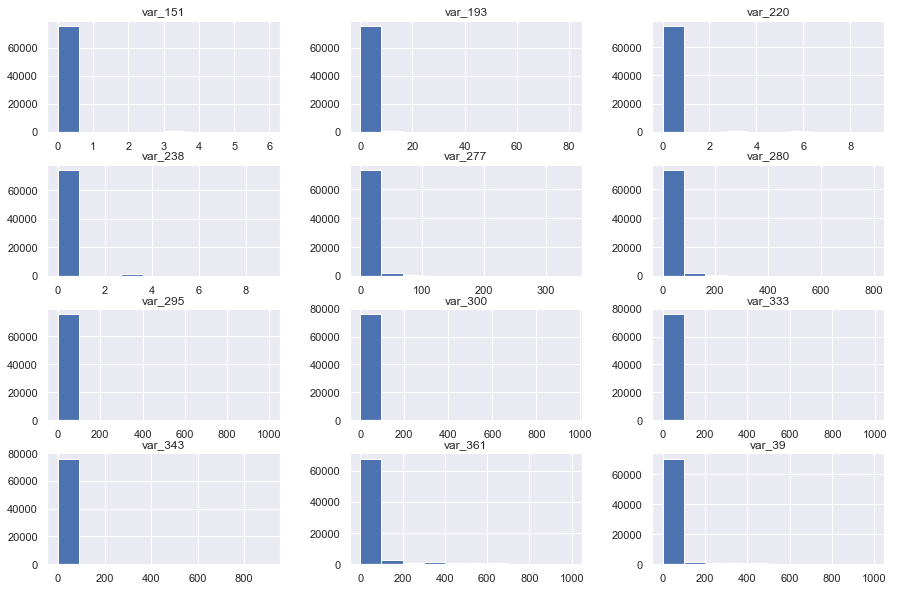

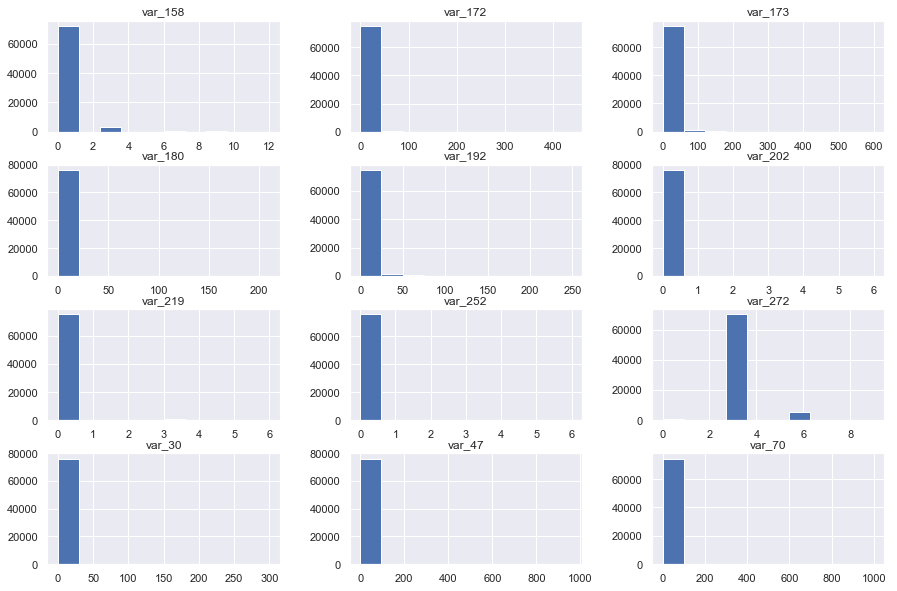

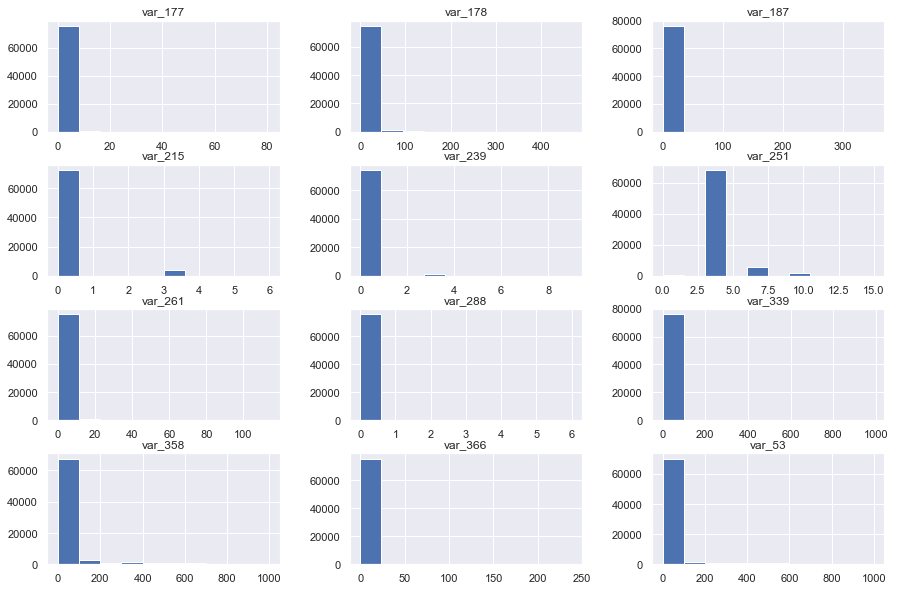

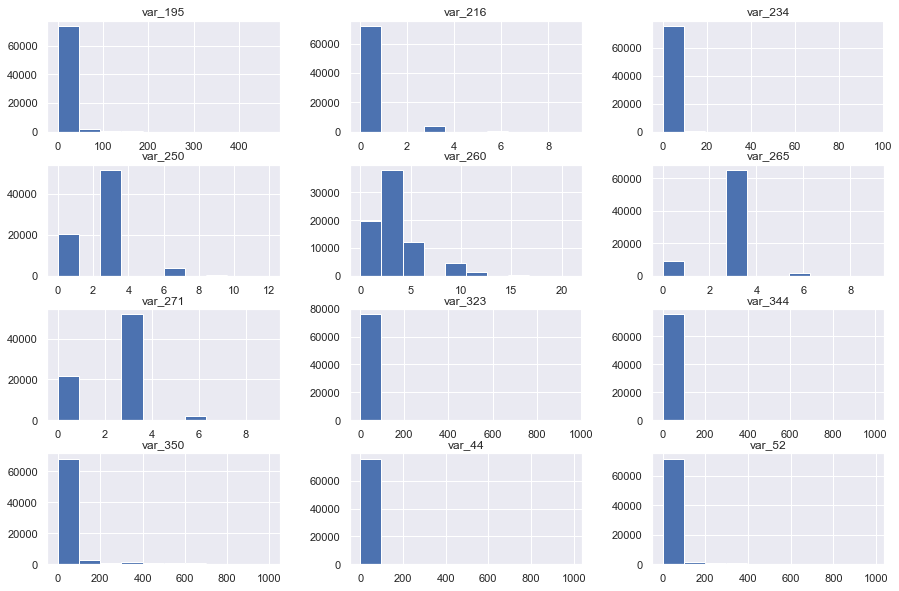

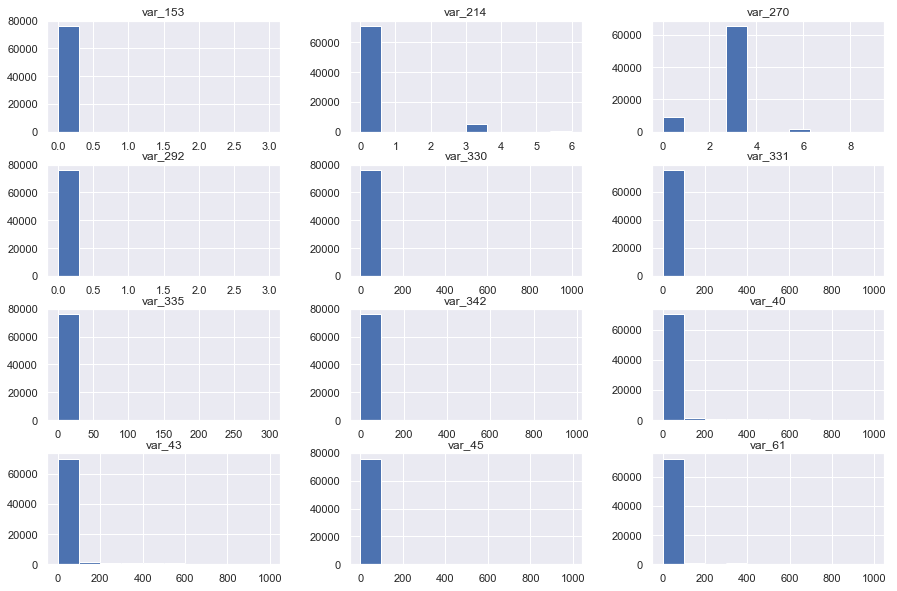

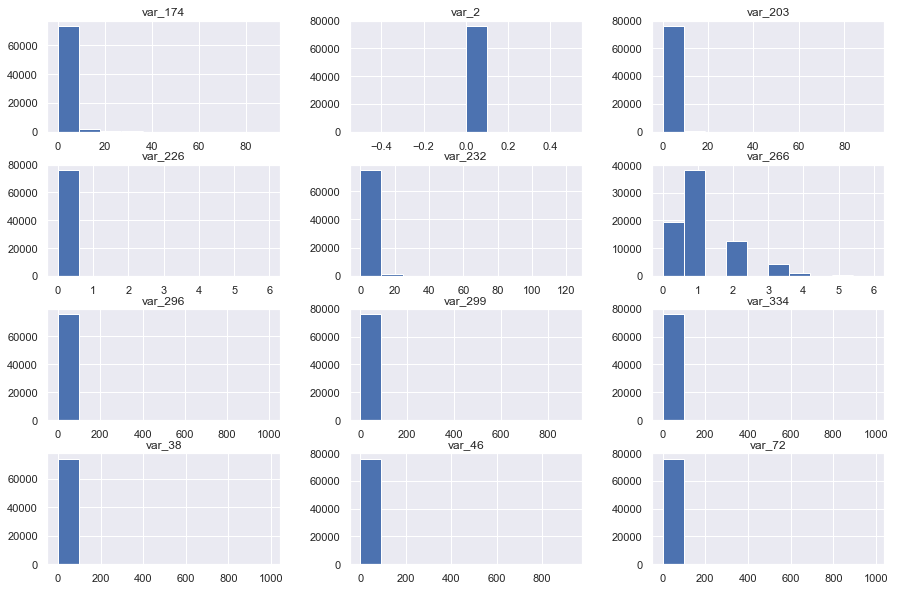

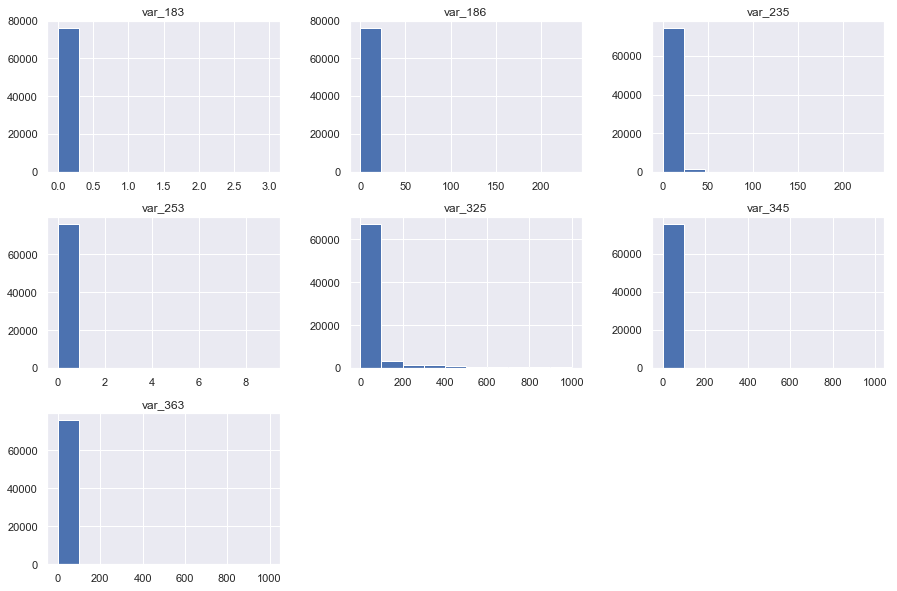

In [1198]:
# histogram for the remaining dataset - cleaned
col_list_rem = split_features(df_rem_data.columns,12)
df_rem_ = pd.DataFrame()
col_subset_rem = list(col_list_rem)

for i in col_subset_rem:
    df_rem_ = df_rem_data[i] #ensure the right dataframe is used
    df_rem_.hist(bins=10,figsize=(15,10))

In [1199]:
## save this first pass file
df_rem_data.to_csv(r"df2_rem_data_final_clean.csv",index=False)

Combine the two processed dataframes;
This will include columns with binary, numerical and categorical data; Does not contain dataframes with all zero values

In [1200]:
## now, get a semi-finalized df ready
## join df_cat_var, df_rem_dat; 
## add columns with binary values only [0,1]
## add ID and TARGET

global df_semi
df_semi = pd.DataFrame()
df_semi = pd.concat([df_cat_var,df_rem_data,df[cols_bin_only]],axis=1)

In [1203]:
len(df_semi.columns)
#check if the dataset contains ID and TARGET
if df_semi.columns.contains('ID'): print("true")
if df_semi.columns.contains('TARGET'): print("true")

true
true


In [1204]:
cols_large_val = df_semi.columns[(df_semi > 900).any()]
df_semi[cols_large_val].describe()

,ID,var_356,var_297,var_41,var_293,var_355,var_60,var_48,var_324,var_51,var_326,var_327,var_321,var_49,var_298,var_50,var_328,var_294,var_42,var_332,var_329,var_39,var_343,var_333,var_361,var_295,var_300,var_70,var_47,var_53,var_358,var_339,var_323,var_52,var_350,var_44,var_344,var_45,var_61,var_331,var_342,var_43,var_40,var_330,var_334,var_296,var_38,var_72,var_46,var_325,var_345,var_363
count,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00
mean,3.26,1.03,0.48,22.07,1.30,13.66,0.17,0.97,0.06,22.01,26.12,58.66,0.07,31.25,0.65,34.41,57.75,1.02,25.64,5.14,2.95,31.78,0.27,1.03,52.93,1.28,0.30,10.27,0.20,35.19,54.30,0.47,0.07,25.55,52.03,1.07,2.64,1.06,21.88,4.55,0.44,35.72,34.68,0.87,1.14,1.50,11.18,0.36,0.18,56.14,2.73,3.31
std,46.53,25.60,16.74,106.45,27.99,79.38,9.83,25.01,6.14,106.23,94.54,151.95,7.37,124.82,21.23,132.60,150.27,24.41,114.71,55.91,41.26,126.08,12.77,25.60,144.82,27.61,12.09,76.84,11.80,136.25,147.82,16.33,6.56,114.44,144.94,24.83,42.59,25.64,111.57,52.73,16.31,137.42,133.24,20.74,26.01,30.32,79.11,15.16,11.05,144.61,43.25,45.08
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.48,3.00,0.00,0.00,0.00,0.00,2.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.83,30.00,0.00,0.00,0.00,0.00,37.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.60,0.00,0.00,0.00,0.00,0.00,19.87,0.00,0.00,0.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,30.00,0.00,0.00
max,1000.00,995.88,999.99,990.00,999.99,998.58,907.14,979.95,958.53,990.00,999.99,999.99,934.86,998.07,999.99,999.84,999.84,999.99,990.00,999.72,996.33,998.07,909.15,995.88,999.93,999.99,960.00,999.99,960.00,998.82,999.93,990.45,958.53,990.00,999.93,990.75,993.09,993.81,997.53,999.81,975.36,998.82,999.84,997.59,990.45,999.99,992.79,990.00,930.00,999.99,993.09,999.33


In [1247]:
## duplicate columns -- if present
df_temp = df_semi['var_14']
df_temp.columns = ['var_14','var_14_2']
for i in df_temp.columns:
    print(df_temp[i].value_counts())

0.00    76017
1.00        3
Name: var_14, dtype: int64
0.00     74340
-1.00     1675
1.00         3
-0.33        1
-0.50        1
Name: var_14_2, dtype: int64


In [1248]:
df_semi.drop(columns='var_14',axis=1,inplace=True)
df_temp.drop(columns='var_14_2',axis=1,inplace=True)
df_semi['var_14'] = df_temp

In [1249]:
rem_neg_val = df_semi.columns[(df_semi <0 ).any()]
len(rem_neg_val)
for col in rem_neg_val:
    print(df_semi[col].value_counts())

 0    76019
-1        1
Name: var_19, dtype: int64
 0    76019
-1        1
Name: var_7, dtype: int64
 0    76018
-1        2
Name: var_9, dtype: int64
0.00     76002
-1.00       17
-0.50        1
Name: var_16, dtype: int64
 0    76014
-1        6
Name: var_11, dtype: int64
0.00     76000
-1.00       17
-0.33        1
1.00         1
2.00         1
Name: var_15, dtype: int64
 0    76014
-1        6
Name: var_23, dtype: int64
 0    76018
-1        2
Name: var_21, dtype: int64


In [1250]:
for col in rem_neg_val:
    df_semi.loc[(df_semi[col] < 0), col] = 0

Method to replace few occureces of large data values

In [1259]:
## find the count of data that are larger than 900; those with fewer than 50 large values, replace them with mean

def replace_large_val(df_,large_val,threshold):
    for col in df_.columns:
        if col == 'ID':
            continue
        else:
            vc_large = df_[col].value_counts()
            if ((vc_large.index.values >= large_val).any()):
                count_large_val = len(vc_large.loc[vc_large.index.values > large_val])
                if count_large_val < threshold:
                    val_replace = vc_large.loc[vc_large.index.values > large_val]
                                
                    df_[col].loc[df_[col].isin(val_replace)] = df_[col].mean()
            else:
                continue          


In [1260]:
replace_large_val(df_semi[cols_large_val],900,50)
df_semi.describe()

C:\Anaconda3\envs\ds19\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,var_185,var_258,var_289,var_229,var_224,var_340,var_34,var_312,var_367,var_33,var_268,var_228,var_209,var_313,var_217,var_264,var_197,var_166,var_25,var_223,var_162,var_267,var_171,var_259,var_311,var_276,var_304,var_230,var_208,var_161,var_168,var_236,var_165,var_213,var_32,var_303,var_255,var_164,var_199,var_169,var_284,var_257,var_73,var_287,var_246,var_67,var_155,var_201,var_222,var_283,var_212,var_198,var_221,var_231,var_207,var_35,var_36,var_152,var_237,var_314,...,var_129,var_98,var_85,var_111,var_78,var_84,var_112,var_105,var_147,var_141,var_137,var_148,var_116,var_102,var_119,var_79,var_149,var_76,var_75,var_117,var_99,var_123,var_91,var_97,var_115,var_82,var_95,var_127,var_80,var_128,TARGET,var_114,var_103,var_126,var_89,var_120,var_122,var_77,var_125,var_104,var_101,var_83,var_135,var_136,var_140,var_86,var_146,var_142,var_144,var_130,var_87,var_19,var_7,var_9,var_16,var_11,var_15,var_23,var_21,var_14
count,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,...,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00
mean,0.00,0.00,0.09,0.03,0.07,0.00,0.00,0.00,40.45,0.00,0.03,0.00,0.00,0.00,0.12,0.01,0.00,0.00,0.00,0.02,0.10,0.01,0.05,0.00,0.00,0.01,0.00,0.01,0.00,0.10,1.59,0.11,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00,2.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.13,0.00,...,0.88,0.00,0.01,0.00,0.05,0.01,0.00,0.02,0.03,0.96,0.00,0.10,0.00,0.02,0.00,0.07,0.09,0.08,0.00,0.00,0.04,0.00,0.00,0.00,1.00,0.04,0.01,0.07,0.05,0.00,0.04,0.73,0.03,0.07,0.02,0.00,0.00,0.09,0.07,0.02,0.02,0.04,0.13,0.00,0.66,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.04,0.02,0.50,0.32,0.46,0.00,0.00,0.00,47.36,0.00,0.32,0.02,0.02,0.00,0.60,0.18,0.07,0.01,0.00,0.22,0.49,0.18,0.33,0.02,0.00,0.13,0.00,0.16,0.03,0.49,0.72,0.57,0.08,0.63,0.00,0.00,0.13,0.01,0.05,0.09,0.66,0.09,0.00,0.02,0.02,0.00,0.03,0.00,0.02,1.43,0.18,0.00,0.02,0.18,0.02,2.31,0.00,0.10,0.61,0.00,...,0.32,0.06,0.10,0.01,0.21,0.10,0.01,0.16,0.18,0.20,0.04,0.30,0.06,0.15,0.03,0.25,0.28,0.27,0.06,0.07,0.19,0.01,0.04,0.05,0.07,0.20,0.11,0.26,0.22,0.06,0.19,0.44,0.16,0.25,0.15,0.03,0.03,0.29,0.25,0.16,0.15,0.20,0.34,0.04,0.47,0.01,0.17,0.01,0.01,0.06,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.

In [1264]:
# check for zero vaues:
cols_zero_semi = df_semi.columns[(df_semi == 0).all()]
len(cols_zero_semi)

8

In [1265]:
# drop columns with all zero values
df_semi.drop(columns=cols_zero_semi,inplace=True)

In [1266]:
df_semi.to_csv(r"df2_semi_clean.csv",index=False)

In [1268]:
## generate heatmap for all variables
def plot_heatmap(df_):
    #X = df_.iloc[:, 0:369]
    f, ax = plt.subplots(figsize=(30, 20))
    corr = df_.corr()
    #print(corr)
    #sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
    #       cmap='YlGnBu', square=True, ax=ax)
    sns.heatmap(corr, cmap='YlGnBu', square=True, ax=ax)

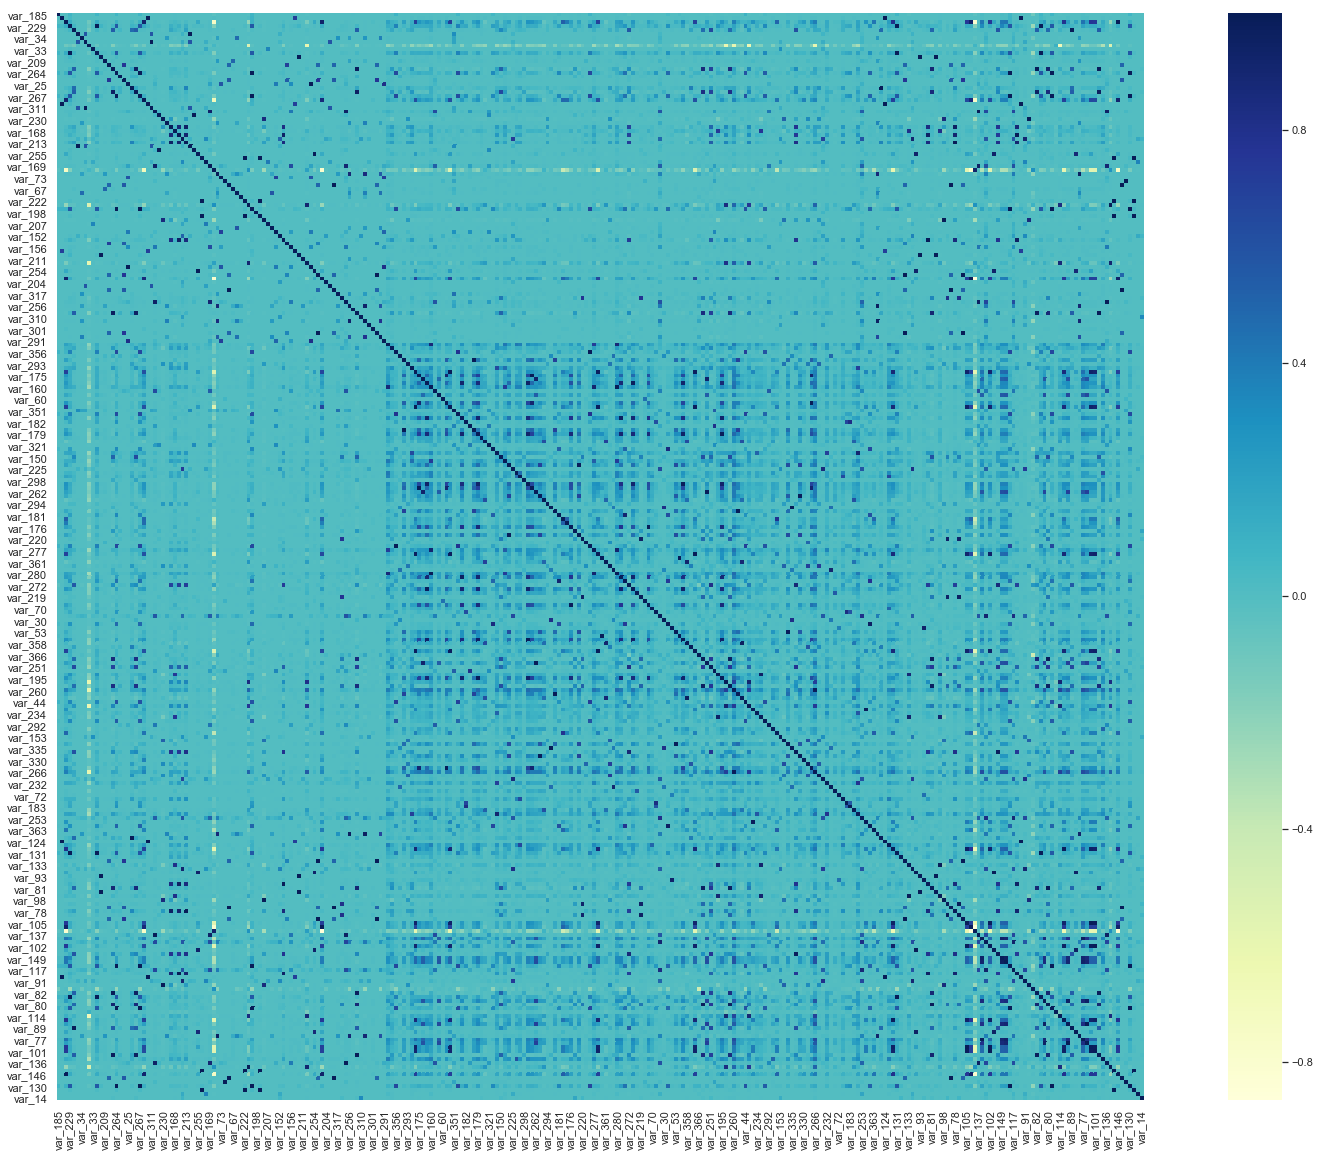

In [1269]:
# correlation matrix for the subset of variables from the orig df; 
plot_heatmap(df_semi)

Trying to find set of columns that may contribute significantly to the target variable

In [1270]:
# idetify relevant features:
corr_target = abs(corr_matx['TARGET'])
relevant_features = corr_target[corr_target > 0.05]
relevant_features

var_170   0.15
var_250   0.14
var_266   0.08
var_271   0.14
var_283   0.13
var_367   0.10
var_364   0.10
var_260   0.08
var_114   0.15
var_140   0.13
TARGET    1.00
Name: TARGET, dtype: float64

In [1271]:
# to plot a heatmap with specied number of variables against Target, k;
def large_corr(df_,corr_matx,k):
    
    cols = corr_matx.nlargest(k, 'TARGET')['TARGET'].index 
    print(len(cols),type(cols))
    corr_coef_m = np.corrcoef(df_[cols].values.T) 
    f1, ax1 = plt.subplots(figsize =(30, 20)) 
    sns.heatmap(corr_coef_m, ax = ax1, cmap ="YlGnBu",linewidths = 0.1, 
                yticklabels = cols.values,xticklabels = cols.values) 
  

150 <class 'pandas.core.indexes.base.Index'>


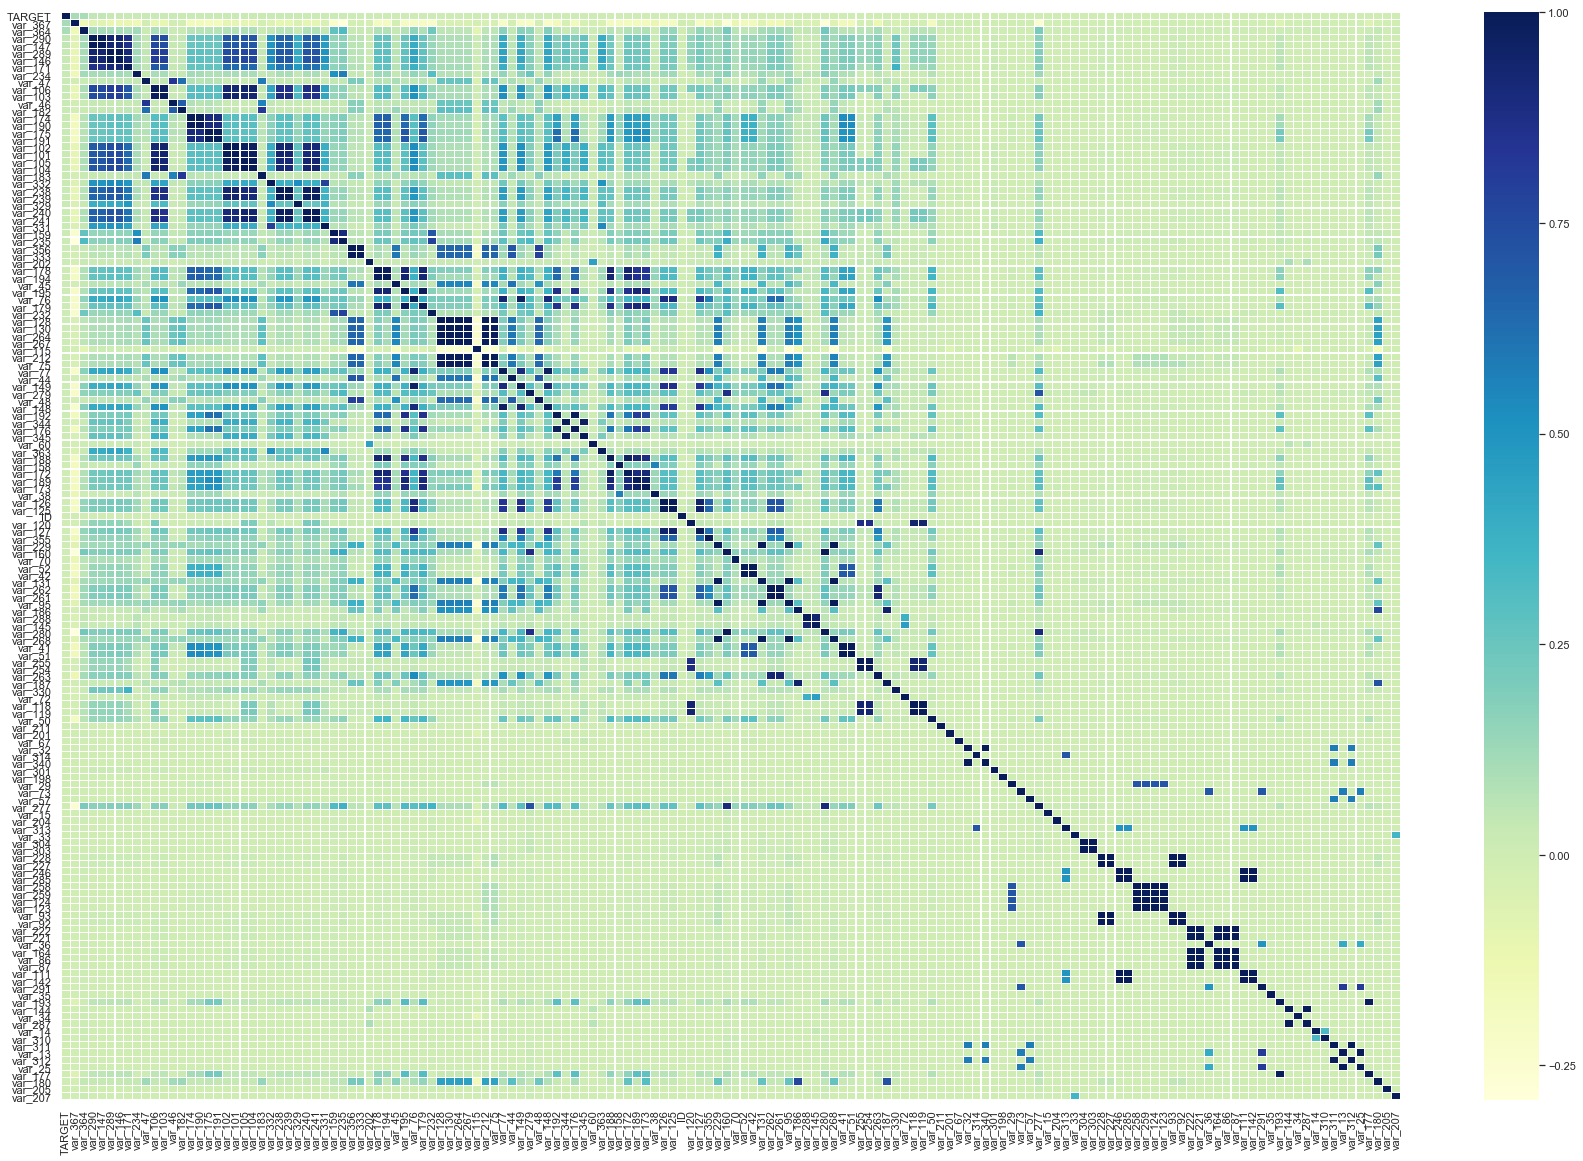

In [1272]:
# pick the variables that have high correlations with target variable
k = 150 # this parameter refers to the number of variables to consider
corr_matx = df_semi.corr()  # correlation matrix for the cleaned dataset

large_corr(df_semi,corr_matx,k)

100 <class 'pandas.core.indexes.base.Index'>


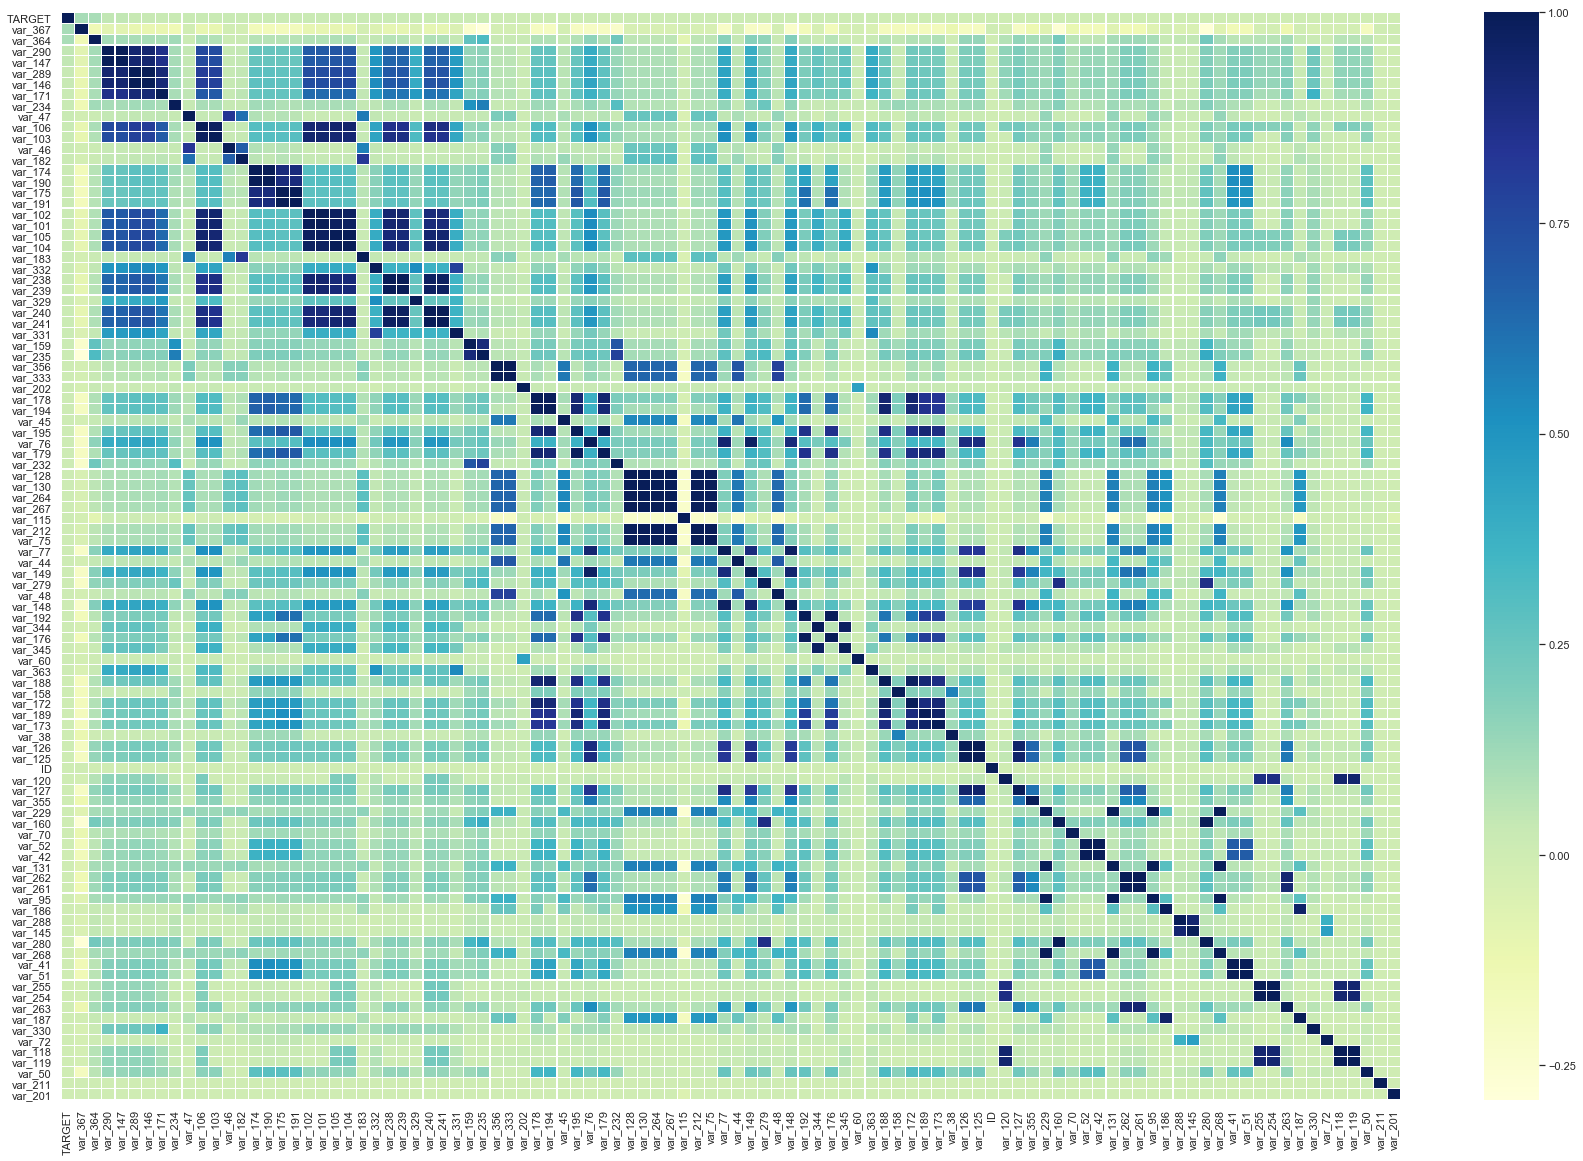

In [1273]:
# plot heatmap for 100 largest correlation values
large_corr(df_semi,corr_matx,100)

In [444]:
# remove duplicated columns;
#df_semi = df_semi.loc[:,~df_semi.columns.duplicated()]

In [1276]:
# correlation of all variables against the target variable
corr_semi = df_semi[df_semi.columns[:]].corr()['TARGET'][:]

In [1277]:
df_semi.to_csv(r"df2_semi_FINAL.csv",index=False)

In [1278]:
saved_col_names = df_semi.columns

In [1279]:
corr_semi

var_185   -0.00
var_258   -0.00
var_289    0.03
var_229    0.00
var_224   -0.02
var_340   -0.00
var_34    -0.00
var_312   -0.00
var_367    0.10
var_33    -0.00
var_268    0.00
var_228   -0.00
var_209   -0.00
var_313   -0.00
var_217   -0.03
var_264    0.01
var_197   -0.00
var_166   -0.00
var_25    -0.00
var_223   -0.01
var_162   -0.03
var_267    0.01
var_171    0.03
var_259   -0.00
var_311   -0.00
var_276   -0.01
var_304   -0.00
var_230   -0.01
var_208   -0.00
var_161   -0.03
           ... 
var_97    -0.01
var_115    0.01
var_82    -0.03
var_95     0.00
var_127    0.00
var_80    -0.04
var_128    0.01
TARGET     1.00
var_114   -0.15
var_103    0.02
var_126    0.00
var_89    -0.02
var_120    0.00
var_122   -0.01
var_77     0.01
var_125    0.00
var_104    0.02
var_101    0.02
var_83    -0.03
var_135   -0.02
var_136   -0.01
var_140   -0.14
var_86    -0.00
var_146    0.03
var_142   -0.00
var_144   -0.00
var_130    0.01
var_87    -0.00
var_15    -0.00
var_14    -0.00
Name: TARGET, Length: 28

## Train the Model

#### Split dataset into training and test data

In [1280]:
from sklearn import preprocessing

In [1281]:
# Train and test set... Do not touch the test set until final testing of your models
X_train, X_test, Y_train, Y_test = train_test_split(df_semi.drop(labels=['TARGET'], axis=1), df_semi['TARGET'], 
                                                    test_size=0.3,random_state=42)

In [1282]:
X_train.shape, X_test.shape

((53214, 279), (22806, 279))

#### Since the datset is sparse, using MaxAbsScaler to scale the data

In [1283]:
# scaling only the training set
max_abs_scaler = preprocessing.MaxAbsScaler()
X_train_maxabs = max_abs_scaler.fit_transform(X_train)
#X_test_max_abs = max_abs_scaler.transform(X_test)

In [1284]:
X_train_maxabs

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Shuffle the scaled training data

In [1286]:
# shuffle the scaled training data

from sklearn.utils import shuffle
X_train_maxabs,Y_train = shuffle(X_train_maxabs,Y_train,random_state=42)

In [1287]:
# remove TARGET
feature_names = df_semi.columns[:-1]

In [1288]:
len(feature_names)

279

### SGDClassifier using L2 penalty

In [1289]:
# SGDClassifier
from sklearn.linear_model import SGDClassifier

# using penalty = l2
sgd_L2 = SGDClassifier(loss="log", penalty="l2", max_iter=200)
sgd_L2.fit(X_train_maxabs, Y_train)   

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=200,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [1290]:
# performance measure using cross-val score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_L2,X_train_maxabs,Y_train,cv=3,scoring='accuracy')

array([0.96065167, 0.96064945, 0.96059086])

In [1291]:
# using cross_val_predict to obtain predicted values using training data
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_L2,X_train_maxabs,Y_train,cv=3)

In [902]:
#Confusion matrix: Each row represents an actual class
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train,y_train_pred)

array([[51122,     8],
       [ 2080,     4]], dtype=int64)

In [1292]:
## precision score & recall score & f1 score

from sklearn.metrics import precision_score, recall_score, f1_score
print("Precision:",precision_score(Y_train,y_train_pred))
print("Recall:",recall_score(Y_train,y_train_pred))
print("F1 score:",f1_score(Y_train,y_train_pred))

Precision: 0.3
Recall: 0.001433349259436216
F1 score: 0.0028530670470756064


In [1293]:
# re-run cross_val_predict using the decision_function as method
y_scores_dec = cross_val_predict(sgd_L2,X_train_maxabs,Y_train,cv=3,method='decision_function')

In [1294]:
pos = np.size(y_scores_dec[y_scores_dec > 0.0])
neg = np.size(y_scores_dec[y_scores_dec < 0.0])

print(pos,neg)

10 53204


##### Defining methods to plot precision vs recall and roc curves

In [1295]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    #plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')


In [ ]:
def precision_recall_threshold(p, r, thresholds, t=0.5):
       
    print(pd.DataFrame(confusion_matrix(Y_test, y_pred)))
                       
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='g')
    plt.ylim([-0.0,0.2]);
    plt.xlim([-0.0,1.0]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line`
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

    

In [1296]:
def plot_roc_curve(fpr, tpr, label=None):
    
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.00, 1, 0, 1.])
    #plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

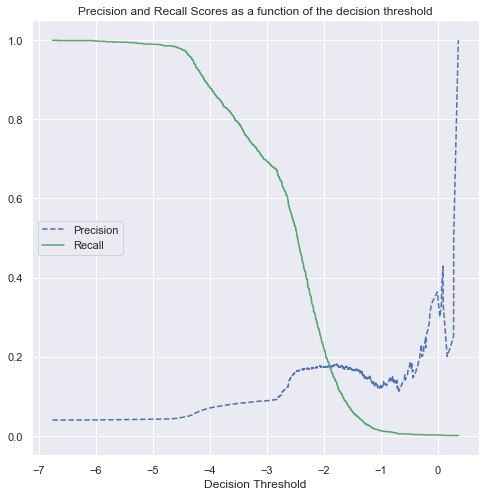

In [1297]:
## using decision_function
precisions, recalls, thresholds = precision_recall_curve(Y_train,y_scores_dec)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


      0      1
0  5660  16234
1   121    791


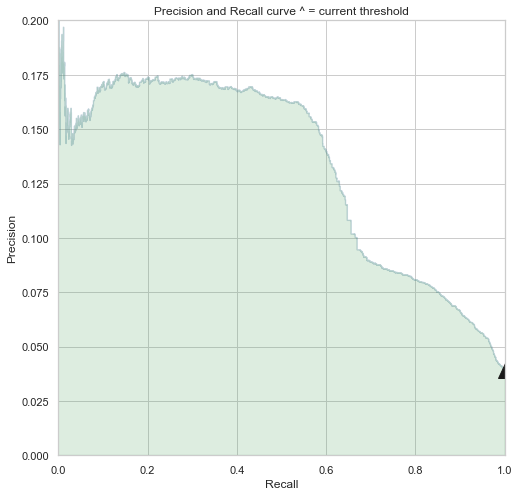

In [963]:
# plot precision recall
precision_recall_threshold(precisions, recalls, thresholds, -200)  

In [1298]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_train,y_scores_dec)

0.7902378506656678

0.7902378506656678


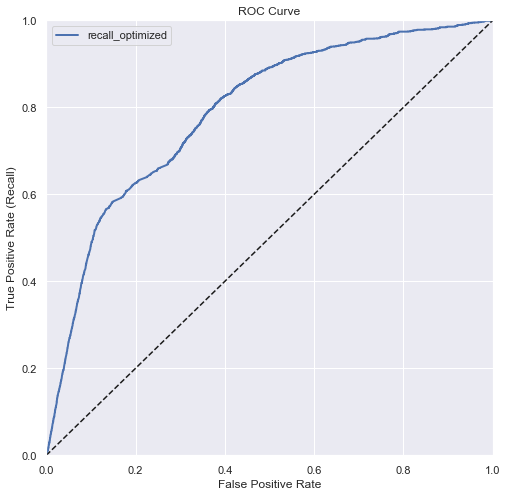

In [1299]:
fpr, tpr, auc_thresholds = roc_curve(Y_train, y_scores_dec)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

##### GridsearchCV - L2 penalty

In [1300]:
from sklearn.metrics import make_scorer, auc
from sklearn.model_selection import GridSearchCV

# GridsearchCV for l2 penalty
params_L2 = {'loss': ['log'],
            'penalty': ['l2'],
             'alpha' : [10.0**x for x in np.arange(-7,1)]
            }
f1 = make_scorer(f1_score)

sgd_l2_grid = GridSearchCV(estimator=sgd_L2,param_grid=params_L2,n_jobs=-1,scoring=f1,cv=3)


In [1301]:
sgd_l2_grid_result = sgd_l2_grid.fit(X_train_maxabs,Y_train)

In [1302]:
best_l2_params = sgd_l2_grid_result.best_params_

In [1303]:
optimal_l2 = SGDClassifier(loss='log',penalty='l2',alpha= 1e-07, max_iter=500)
optimal_l2.fit(X_train_maxabs, Y_train)

SGDClassifier(alpha=1e-07, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=500,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [1304]:
# testing the optimal L2 model on the test set
y_pred_grid = optimal_l2.predict(X_test)
f1_score(Y_test,y_pred_grid)

0.08914666237044197

In [1305]:
# save the l2 model
from sklearn.externals import joblib
joblib.dump(optimal_l2,'optimal_l2.pkl')

['optimal_l2.pkl']

### SGDClassifier using L1 penalty

In [1306]:
## SGD classifier with L1 penalty

sgd_L1 = SGDClassifier(loss="log", penalty="l1", max_iter=200)
sgd_L1.fit(X_train_maxabs, y)   


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=200,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [949]:
# performance measure using cross-val score -- L1
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_L1,X_train_maxabs,Y_train,cv=3,scoring='accuracy')


array([0.96082079, 0.96087496, 0.96070361])

In [1307]:
# obtaining predictions using cross_val_predict method
from sklearn.model_selection import cross_val_predict
y_train_pred_L1 = cross_val_predict(sgd_L1,X_train_maxabs,Y_train,cv=3)

#confusion matrix: Each row represents an actual class -- L1
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train,y_train_pred_L1)


array([[51115,     6],
       [ 2092,     1]], dtype=int64)

In [1308]:
## precision score & recall score & f1 score --- L1

print("Precision:",precision_score(Y_train,y_train_pred_L1))
print("Recall:",recall_score(Y_train,y_train_pred_L1))
print("F1 score:",f1_score(Y_train,y_train_pred_L1))

Precision: 0.14285714285714285
Recall: 0.00047778308647873863
F1 score: 0.0009523809523809522


In [1309]:
# re-run cross_val_predict using the decision_function as method --- L1
y_scores_dec_L1 = cross_val_predict(sgd_L1,X_train_maxabs,Y_train,cv=3,method='decision_function')


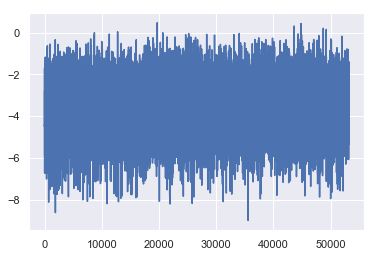

In [1310]:
# plotting the decision scores obtained from cross_val_predict method
plt.plot(y_scores_dec_L1)


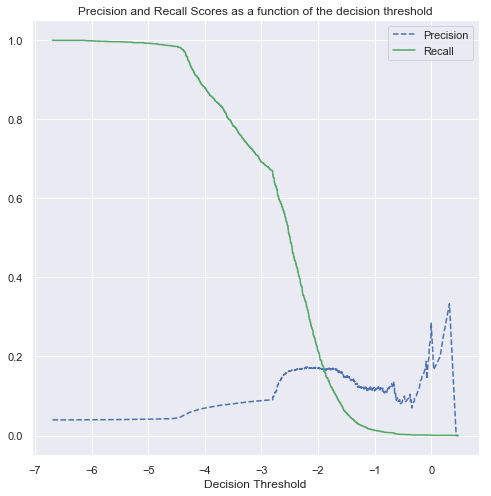

In [1311]:
# plot precision recall curve
p_L1, r_L1, th_L1 = precision_recall_curve(Y_train,y_scores_dec_L1)
plot_precision_recall_vs_threshold(p_L1,r_L1,th_L1)

      0      1
0  5657  16234
1   124    791


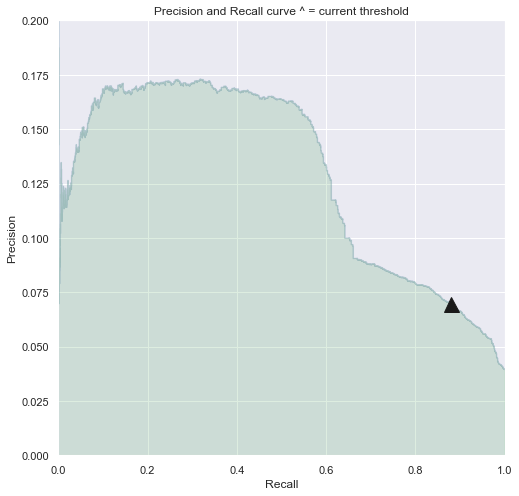

In [1312]:
precision_recall_threshold(p_L1, r_L1, th_L1, -4)  

0.7920898314074607


0.7920898314074607

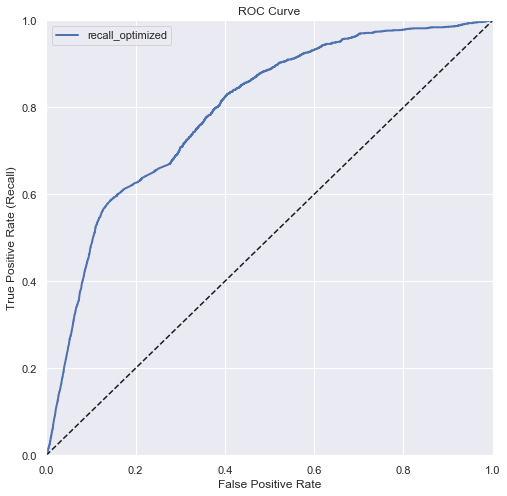

In [1313]:
# plotting roc curve based on training data
fpr_l1, tpr_l1, auc_th_l1 = roc_curve(Y_train, y_scores_dec_L1)
print(auc(fpr_l1, tpr_l1)) # AUC of ROC
plot_roc_curve(fpr_l1, tpr_l1, 'recall_optimized')

from sklearn.metrics import roc_auc_score
roc_auc_score(Y_train,y_scores_dec_L1)

##### GridsearchCV - L1 penalty

In [1316]:
# GridsearchCV for l1 penalty
params_L1 = {'loss': ['log'],
            'penalty': ['l1'],
             'alpha' : [10.0**x for x in np.arange(-7,1)]
            }
f1 = make_scorer(f1_score)
sgd_l1_grid = GridSearchCV(estimator=sgd_L1,param_grid=params_L1,n_jobs=-1,scoring=f1,cv=3)



In [1317]:
# use training data to fit -- takes about 2-3 min to run
sgd_l1_grid_results = sgd_l1_grid.fit(X_train_maxabs,Y_train)
best_l1_params = sgd_l1_grid_results.best_params_

In [1318]:
best_l1_params

{'alpha': 1e-07, 'loss': 'log', 'penalty': 'l1'}

In [1319]:
optimal_l1 = SGDClassifier(loss='log',penalty='l1',alpha= 1e-07, max_iter=500)
optimal_l1.fit(X_train_maxabs, Y_train)

SGDClassifier(alpha=1e-07, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=500,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [1320]:
# testing the optimal L1 model on the test set
y_pred_grid_l1 = optimal_l1.predict(X_test)
f1_score(Y_test,y_pred_grid_l1)


0.0900786063309964

In [1321]:
# save the l1 model
from sklearn.externals import joblib
joblib.dump(optimal_l1,'optimal_l1.pkl')

['optimal_l1.pkl']

### SGDClassifier using 'elasticnet' penalty

In [1322]:
## SGD classifier with 'elasticnet' penalty

sgd_e = SGDClassifier(loss="log", penalty="elasticnet", max_iter=200)
sgd_e.fit(X_train_maxabs, y)   


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=200,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [1323]:
sged_e_params = sgd_e.get_params()
sged_e_params

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'log',
 'max_iter': 200,
 'n_iter': None,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'elasticnet',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': None,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [1324]:
# performance measure using cross-val score -- elasticnet
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_e,X_train_maxabs,Y_train,cv=3,scoring='accuracy')

array([0.96053893, 0.96059308, 0.96053448])

In [1325]:
# obtaining predictions using cross_val_predict  --- elasticnet
from sklearn.model_selection import cross_val_predict
y_train_pred_e = cross_val_predict(sgd_e,X_train_maxabs,Y_train,cv=3)


In [1326]:
#Confusion matrix Each row represents an actual class -- elasticnet
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train,y_train_pred_e)


array([[51114,     7],
       [ 2091,     2]], dtype=int64)

In [1327]:
## precision score & recall score & f1 score --- elasticnet

print("Precision:",precision_score(Y_train,y_train_pred_e))
print("Recall:",recall_score(Y_train,y_train_pred_e))
print("F1 score:",f1_score(Y_train,y_train_pred_e))

Precision: 0.2222222222222222
Recall: 0.0009555661729574773
F1 score: 0.0019029495718363464


In [1328]:
# re-run cross_val_predict using the decision_function as method --- elasticnet
y_scores_dec_e = cross_val_predict(sgd_e,X_train_maxabs,Y_train,cv=3,method='decision_function')


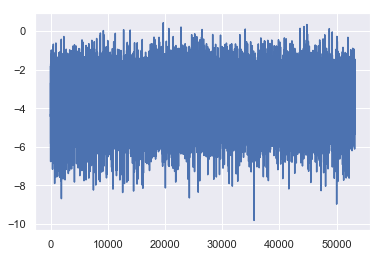

In [1329]:
# plotting the decision scores obtained from cross_val_predict method
plt.plot(y_scores_dec_e)


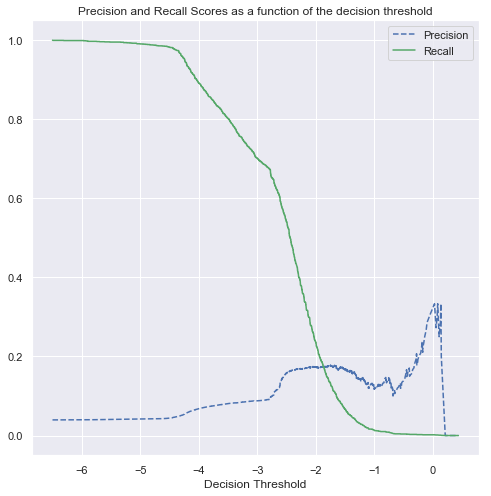

In [1330]:
# plot precision recall curve
p_e, r_e, th_e = precision_recall_curve(Y_train,y_scores_dec_e)
plot_precision_recall_vs_threshold(p_e,r_e,th_e)

      0      1
0  5657  16234
1   124    791


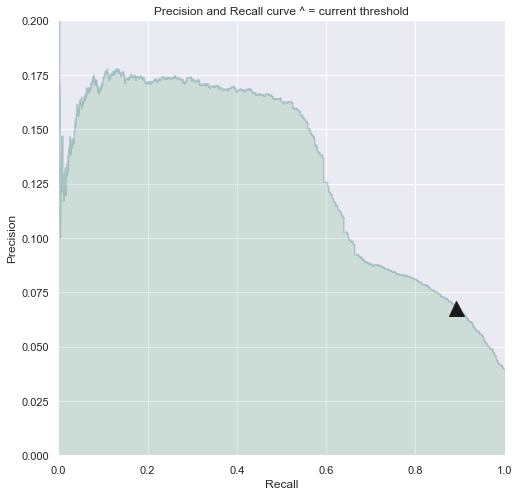

In [1331]:
precision_recall_threshold(p_e, r_e, th_e, -4)  

0.7912975279610959


0.7912975279610959

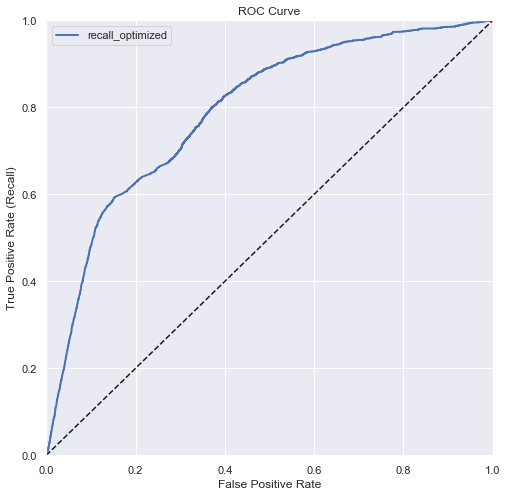

In [1332]:
# plotting roc curve based on training data
fpr_e, tpr_e, auc_th_e = roc_curve(Y_train, y_scores_dec_e)
print(auc(fpr_e, tpr_e)) # AUC of ROC
plot_roc_curve(fpr_e, tpr_e, 'recall_optimized')

from sklearn.metrics import roc_auc_score
roc_auc_score(Y_train,y_scores_dec_e)

##### GridsearchCV with elasticnet penalty

In [1333]:
# GridsearchCV for elasticnet penalty
params_e = {'loss': ['log'],
            'penalty': ['elasticnet'],
             'alpha' : [10.0**x for x in np.arange(-7,1)],
             #'l1_ratio' : [.1, .5, .7, .9, .95, .99, 1] # ORIGINAL pass
            'l1_ratio' : [.85, .9, .95, .99]
            }
f1 = make_scorer(f1_score)
sgd_e_grid = GridSearchCV(estimator=sgd_e,param_grid=params_e,n_jobs=-1,scoring=f1,cv=3)

In [1335]:
############ TAKES 7-10 min to run!! #################
# use training data to fit 
sgd_e_grid.fit(X_train_maxabs,Y_train)

# get the best parameters
print(sgd_e_grid.best_params_)


C:\Anaconda3\envs\ds19\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Anaconda3\envs\ds19\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Anaconda3\envs\ds19\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Anaconda3\envs\ds19\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:700: UserWa

{'loss': 'log', 'alpha': 1e-07, 'l1_ratio': 0.85, 'penalty': 'elasticnet'}


In [1336]:
# obtain prediction on the test data
y_pred_grid_e = sgd_e_grid.predict(X_test)

In [1337]:
# confusion matrix based on gridsearchCV prediction
confusion_matrix(Y_test,y_pred_grid_e)


array([[ 6327, 15564],
       [   96,   819]], dtype=int64)

In [1338]:
f1_score(Y_test,y_pred_grid_e)

0.09469302809573361

In [1339]:

optimal_e = SGDClassifier(loss='log',penalty='elasticnet',alpha= 1e-07, l1_ratio=0.9, max_iter=200)
optimal_e.fit(X_train_maxabs, Y_train)

SGDClassifier(alpha=1e-07, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.9, learning_rate='optimal', loss='log', max_iter=200,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [1340]:
# testing the optimal elasticnet model on the test set
y_pred_grid_e = optimal_e.predict(X_test)
f1_score(Y_test,y_pred_grid_e)

0.08354965868666475

In [1341]:
# save the elasticnet model
from sklearn.externals import joblib
joblib.dump(optimal_e,'optimal_elasticnet.pkl')

['optimal_elasticnet.pkl']